In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
atlas_name = 'atlasV5'

In [8]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
download_from_s3(fp)
instance_centroids_rel2fixed = load_pickle(fp)

In [4]:
ann_vol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack='MD589', volume_type='annotation', downscale=32)
print 'annotation volume bbox (rel2uncropped):', ann_vol_bbox_rel2uncropped

annotation volume bbox (rel2uncropped): [ 622 1042  155  502  128  503]


In [5]:
canonical_locations_rel2canon, canonical_centroid_rel2fixed, canonical_normal = \
average_location(instance_centroids_rel2fixed)

canonical_centroid_rel2uncropped = canonical_centroid_rel2fixed + ann_vol_bbox_rel2uncropped[[0,2,4]]
print 'canonical_centroid_rel2uncropped', canonical_centroid_rel2uncropped

[ 0.04111027 -0.09160432  0.99494653] @ [ 172.0630378   223.21016434  186.74030921]
canonical_centroid_rel2uncropped [ 794.0630378   378.21016434  314.74030921]


In [6]:
canonical_locations_rel2fixed = {k: canonical_centroid_rel2fixed + c_rel2canon 
                                 for k, c_rel2canon in canonical_locations_rel2canon.iteritems()}

In [7]:
print 'deviation angle:', np.rad2deg(np.arccos(canonical_normal[2]))

deviation angle: 5.76256199381


In [8]:
canonical_midplane_xx, canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
canonical_midplane_z = -(canonical_normal[0]*(canonical_midplane_xx-canonical_centroid_rel2fixed[0]) + \
canonical_normal[1]*(canonical_midplane_yy-canonical_centroid_rel2fixed[1]) + \
canonical_normal[2]*(-canonical_centroid_rel2fixed[2]))/canonical_normal[2]

In [9]:
# radii_allStructures = {}
# ellipsoid_matrix_allStructures = {}
# for name_s, centroids in sorted(instance_centroids_rel2fixed.items()):
#     centroids2 = np.array(centroids)
#     cov_mat = np.cov(centroids2.T)
#     u, s, vt = np.linalg.svd(cov_mat)
# #     print name_s, u[:,0], u[:,1], u[:,2],
#     radii_allStructures[name_s] = np.sqrt(s)
#     ellipsoid_matrix_allStructures[name_s] = vt

In [10]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# for name_s, centroids in instance_centroids_rel2fixed.iteritems():
# #     if name_s == '7N_L' or name_s == '7N_R':
#     centroids2 = np.array(centroids)
#     ax.scatter(centroids2[:,0], centroids2[:,1], centroids2[:,2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                marker='o', s=100, alpha=.1)
    
#     c = canonical_locations_rel2fixed[name_s]
#     ax.scatter(c[0], c[1], c[2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)
    
#     # Plot uncerntainty ellipsoids
#     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     v = np.linspace(0.0, np.pi, 100)
#     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     for i in range(len(u)):
#         for j in range(len(v)):
#             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

# #     ax.plot_surface(x, y, z, color='b')
#     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    
# ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#            color=(0,0,0), marker='^', s=200)

# # Plot mid-sagittal plane
# ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# # ax.set_xlabel('X Label')
# # ax.set_ylabel('Y Label')
# # ax.set_zlabel('Z Label')
# # ax.set_axis_off()
# ax.set_xlim3d([0, 400]);
# ax.set_ylim3d([0, 400]);
# ax.set_zlim3d([0, 400]);
# # ax.view_init(azim = 90 + 20,elev = 0 - 20)
# ax.view_init(azim = 90,elev = 0)
# ax.set_aspect(1.0)
# plt.legend()
# plt.show()

In [9]:
# Load human correction.

human_correction_transforms = defaultdict(dict)

for stack_fixed in all_nissl_stacks:

    structures = load_hdf_v2(DataManager.get_annotation_filepath(stack=stack_fixed, 
                                                by_human=True,
                               timestamp='latest', suffix='structures'))

    for _, entry in structures.iterrows():

        tf = np.eye(4)
        edits = entry['edits']
        for edit in edits:
            if 'type' in edit:
                if edit['type'] == 'shift3d' or edit['type'] == 'rotation3d':
                    T = consolidate(edit['transform'], edit['centroid_m'], edit['centroid_f'])
                    tf = np.dot(tf, T)
        print entry['name'], entry['side'], tf[:3,-1]

        name_s = compose_label(structure_name=entry['name'], side=entry['side'])
        human_correction_transforms[stack_fixed][name_s] = tf

    print '\n'
    
human_correction_transforms.default_factory = None

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD585" "/home/yuncong/CSHL_labelings_v3/MD585" --exclude "*" --include "*structures*"
latest timestamp:  11012017011336
SNC R [  69.67381098 -121.02943746  320.08680801]


aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*structures*"
latest timestamp:  10312017220310
3N L [ 12.97114132  -3.29425811  -8.39212254]
3N R [ -1.48241615  -0.82356453  78.07391729]
4N R [ 23.75616484  11.29005854   0.        ]


aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD590" "/home/yuncong/CSHL_labelings_v3/MD590" --exclude "*" --include "*structures*"
latest timestamp:  10312017221118
3N L [  0.           0.55147171 -24.69805423]
4N R [ 12.70131586   7.19741232   0.        ]
3N R [  0.          -0.03939084  28.47957449]
4N L [ 91.28828467  54.90430189  25.93635298]


aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelin

In [40]:
adjustments_global_pos_to_local_pos = defaultdict(dict)
adjustments_local_pos_to_human_pos = defaultdict(dict)

adjusted_structure_centroids_rel2atlas = defaultdict(dict)

for s in all_known_structures_sided:
    try:
        c = canonical_locations_rel2fixed[s]
        for stack in all_nissl_stacks:
            global_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=20)

            Gas = consolidate(global_params, centroid_m, centroid_f)

            local_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=17,
                                                  structure_f=s,
                                                  structure_m=s)
            Lss = consolidate(local_params, centroid_m, centroid_f)
            
            adjustments_global_pos_to_local_pos[s][stack] = Lss[:3, 3]
            
            #################################
           
            if s in human_correction_transforms[stack]:
                tf_guiVolResol = human_correction_transforms[stack][s]
                tf_volResol = tf_guiVolResol.copy()
                tf_volResol[:3,3] = tf_guiVolResol[:3,3]/4.
                Lss = np.dot(tf_volResol, Lss)
                
                adjustments_local_pos_to_human_pos[s][stack] = tf_volResol[:3, 3]
            else:
#                 adjustments_local_pos_to_human_pos[s][stack] = np.eye(4)
                adjustments_local_pos_to_human_pos[s][stack] = np.array([0,0,0])

            ##################################
            
            Gas_inv = np.linalg.inv(Gas)
            Laa = np.dot(Gas_inv, np.dot(Lss, Gas))
            
            ##################################
                    
            adjusted_structure_centroids_rel2atlas[s][stack] = np.dot(Laa[:3, :3], c) + Laa[:3, 3]
    except Exception as e:
        sys.stderr.write("Cannot compute centroid in atlas space for %s: %s\n" % (s, e))
        
adjusted_structure_centroids_rel2atlas.default_factory = None

adjustments_global_pos_to_local_pos.default_factory = None
adjustments_local_pos_to_human_pos.default_factory = None

In [35]:
import pandas as pd

In [41]:
pd.DataFrame(adjustments_local_pos_to_human_pos)

,10N_L,10N_R,12N,3N_L,3N_R,4N_L,4N_R,5N_L,5N_R,6N_L,...,Sp5O_L,Sp5O_R,Tz_L,Tz_R,VCA_L,VCA_R,VCP_L,VCP_R,VLL_L,VLL_R
MD585,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD589,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[3.24278533049, -0.823564528379, -2.09803063604]","[-0.37060403777, -0.205891132095, 19.5184793226]","[0, 0, 0]","[5.9390412106, 2.82251463474, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD590,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 0.137867926306, -6.17451355669]","[0.0, -0.00984770902184, 7.11989362279]","[22.8220711674, 13.726075473, 6.48408824483]","[3.17532896408, 1.79935307965, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD591,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[-4.17010297569, 0.0, -22.0935881806]","[0.166771816997, 0.0, -3.83575179092]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD592,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0, 0, 0]","[35.1869316161, -3.03557551685, 8.33859084983]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD593,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.617673396284, 0.0, 8.23564528379]","[-0.0165796598268, 0.0, -11.6855499662]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD594,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 3.00601052858, -10.52103685]","[0.0, 1.40005969824, 3.12954520784]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD595,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD598,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[4.07664441547, 0.0, -16.6771816997]","[2.84129762291, 0.0, 0.679440735912]","[32.8640014184, -10.8766662135, -2.56661826358]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD599,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, -1.44123792466, -13.7947058503]","[0.0, 0.0, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"


In [42]:
pd.DataFrame(adjustments_global_pos_to_local_pos)

,10N_L,10N_R,12N,3N_L,3N_R,4N_L,4N_R,5N_L,5N_R,6N_L,...,Sp5O_L,Sp5O_R,Tz_L,Tz_R,VCA_L,VCA_R,VCP_L,VCP_R,VLL_L,VLL_R
MD585,"[79.5777683184, -37.764583448, -66.6990213336]","[107.364296395, -61.417038417, -72.6035121051]","[63.021602717, -24.3539623477, -67.3811918715]","[-61.623712859, 48.6940978438, 18.1994920602]","[-31.1978420553, -65.0725430024, 133.840354663]","[-0.611983263699, 31.0422726192, -25.0742970961]","[0.985788752601, 18.6343774161, -13.8270408166]","[15.6568404432, 8.02865913888, -50.3706882752]","[3.06792959885, -65.1319272093, 83.7051835884]","[-0.0255759686922, -21.8158807791, 45.7570563051]",...,"[89.5834234952, -83.9504804881, 96.4035029335]","[116.398114696, 29.3631188976, -111.700902907]","[61.2072872895, -0.172217153751, -52.2390699091]","[23.7849378206, -33.1940001864, 36.006679987]","[6.63047495635, 5.61156577738, -64.5414258641]","[15.9696483612, -49.5014901128, 42.308196915]","[18.337263346, -8.12306539749, -55.0783397571]","[24.672584388, -39.9897656581, 27.5652417201]","[86.3389794263, -7.24650124501, -95.4039632712]","[0.98858661932, -88.0976330339, 103.257950571]"
MD589,"[-13.5213096146, 20.6782408888, 4.86253412989]","[-15.994884003, 21.2180921972, 6.23088423952]","[-19.6701053513, 16.4812765826, 9.86542074223]","[7.08804138829, -37.6769878549, 41.3345450782]","[-15.0857410097, -40.3879266995, 46.736294707]","[5.00355011153, -26.4346580485, 35.6764403079]","[-58.7999848594, 73.2779429222, 13.6231082434]","[-3.42878297877, 14.9451109495, -22.6658717008]","[-17.0123974114, -59.7727668431, 96.7692772719]","[18.8814016582, -37.8208675204, 47.1833888775]",...,"[73.2913788113, -74.5176954333, 108.307600313]","[88.4100457137, 38.6405593491, -94.3701089926]","[27.1389256094, -17.9823304838, 15.0446493647]","[21.4243147524, -18.9675381333, 24.9075323898]","[-11.5715589459, 14.5052554452, -50.1335263189]","[-36.7763116013, 10.4297525773, 29.5942457647]","[2.46587604947, -5.61753651967, -0.990756484116]","[33.9856913893, -45.2224721784, 23.3310352193]","[69.5382484468, -6.35608413912, -104.351692755]","[-44.6948688162, -70.9934393554, 110.169299228]"
MD590,"[31.3229017758, -15.6967498409, -34.2248956226]","[28.2780218469, -22.8514691824, -23.5014691775]","[3.59066189085, -1.20645627921, -7.37255065257]","[-83.1166854797, 231.187960183, -3.5939676498]","[-33.9967429385, -9.84231258075, 327.548306152]","[71.9071239413, -56.7635460012, -14.3352936291]","[-6.63432702949, 53.81300652, -30.382639686]","[2.49483391051, 22.165549267, -44.6617818582]","[64.3907311236, -51.0083047029, 20.7951801274]","[11.0183507644, -35.0152441621, 64.7429036394]",...,"[-46.0071036626, 72.9748275831, -132.026349868]","[-44.1002187169, -50.7495900032, 25.3717641554]","[-15.2953025803, 23.9428543063, -21.6223396486]","[28.9669836683, -29.6470780777, 32.8314361814]","[-4.99002939583, 1.61156454679, -39.3179806318]","[-5.44316334029, -27.1355374383, 34.5572387261]","[67.1128981149, -44.6215459225, -74.7881715086]","[35.766981547, -80.3860475264, 57.0470536486]","[111.065479429, -26.5288177898, -91.3294782455]","[-40.0756165584, -71.5314682364, 102.508639823]"
MD591,"[-6.59173460434, -9.88943731255, 21.1279289146]","[4.80823004679, -12.0495908988, 18.3021544078]","[-21.5343359687, -4.31506073022, 42.6053021508]","[61.4456035034, 12.9542979347, -19.7323741795]","[44.5621354981, 13.0553965529, -28.5748211185]","[-9.40518872288, -13.7150138226, 44.0291361326]","[-2.31196646922, 10.6751677308, -1.08789996057]","[47.2925875183, -3.08507194621, -43.4955673935]","[42.471087666, -76.2493055281, 65.9518935257]","[22.4341644251, -36.5465915032, 63.0496435528]",...,"[55.3352869207, -56.973642469, 97.9629484976]","[85.095348327, -34.6563272845, -39.4227037332]","[17.4691276768, -9.36901420704, 17.2416209341]","[36.1522282383, -32.3555415041, 36.758757273]","[-6.76715778903, 6.81686083067, -32.326761781]","[-36.782664912, -35.8459900499, 83.1484621249]","[92.4026751063, -63.4842825292, -34.9899273553]","[14.0513013049, -32.4242436646, 28.0258099943]

In [11]:
new_mean_centroids_rel2atlas_allstructures = {}
instance_centroids_deviations_allstructures = defaultdict(dict)
for s, centroids_rel2atlas_allstacks in adjusted_structure_centroids_rel2atlas.iteritems():
    new_mean_centroids_rel2atlas_allstructures[s] = np.mean(centroids_rel2atlas_allstacks.values(), axis=0)
    for st, c in centroids_rel2atlas_allstacks.iteritems():
        instance_centroids_deviations_allstructures[s][st] = c - new_mean_centroids_rel2atlas_allstructures[s]

In [12]:
# Identify outlier

outliers_allstructures = {}
# dxs_allstructures_outlierRemoved = {}
new_mean_centroids_rel2atlas_allstructures_outlierRemoved = {}

for s, ps_allstacks in sorted(instance_centroids_deviations_allstructures.items()):
    vals = np.linalg.norm(np.array(ps_allstacks.values()), axis=1)
    first_quartile = np.percentile(vals, 20)
    third_quartile = np.percentile(vals, 80)
    IQR = third_quartile - first_quartile
    is_outlier = (vals < first_quartile - 1 * IQR) | (vals > third_quartile + 1 * IQR)
#     dxs_allstructures_outlierRemoved[s] = vals[~is_outlier]
    
#     if np.count_nonzero(is_outlier) > 0:
    outlier_indices = np.where(is_outlier)[0]
    outliers_allstructures[s] = [ps_allstacks.keys()[i] for i in outlier_indices]

    print s, outliers_allstructures[s]
    
    new_mean_centroids_rel2atlas_allstructures_outlierRemoved[s] = \
    np.mean([adjusted_structure_centroids_rel2atlas[s][st]
             for st in set(ps_allstacks.keys())-set(outliers_allstructures[s])], 
            axis=0)
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
# write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

10N_L []
10N_R []
12N []
3N_L ['MD593']
3N_R []
4N_L []
4N_R []
5N_L []
5N_R ['MD603']
6N_L ['MD585']
6N_R ['MD589']
7N_L ['MD598']
7N_R []
7n_L []
7n_R []
AP []
Amb_L ['MD590']
Amb_R []
DC_L ['MD603', 'MD595']
DC_R ['MD598', 'MD599']
IC ['MD603']
LC_L ['MD593']
LC_R []
LRt_L []
LRt_R []
PBG_L []
PBG_R ['MD595', 'MD589']
Pn_L ['MD598']
Pn_R []
RMC_L []
RMC_R ['MD585']
RtTg []
SC ['MD603', 'MD589']
SNC_L []
SNC_R ['MD598']
SNR_L ['MD595', 'MD598']
SNR_R []
Sp5C_L []
Sp5C_R ['MD603']
Sp5I_L []
Sp5I_R ['MD585']
Sp5O_L ['MD594']
Sp5O_R []
Tz_L []
Tz_R []
VCA_L ['MD595']
VCA_R []
VCP_L ['MD603', 'MD595']
VCP_R ['MD595']
VLL_L []
VLL_R ['MD603']


In [13]:
# OR ignore outlier 

outliers_allstructures = {}
# dxs_allstructures_outlierRemoved = {}
new_mean_centroids_rel2atlas_allstructures_outlierRemoved = {}

for s, ps_allstacks in sorted(instance_centroids_deviations_allstructures.items()):
    outliers_allstructures[s] = {} 

    print s, outliers_allstructures[s]
    
    new_mean_centroids_rel2atlas_allstructures_outlierRemoved[s] = \
    np.mean([adjusted_structure_centroids_rel2atlas[s][st]
             for st in set(ps_allstacks.keys())-set(outliers_allstructures[s])], 
            axis=0)
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
# write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

10N_L {}
10N_R {}
12N {}
3N_L {}
3N_R {}
4N_L {}
4N_R {}
5N_L {}
5N_R {}
6N_L {}
6N_R {}
7N_L {}
7N_R {}
7n_L {}
7n_R {}
AP {}
Amb_L {}
Amb_R {}
DC_L {}
DC_R {}
IC {}
LC_L {}
LC_R {}
LRt_L {}
LRt_R {}
PBG_L {}
PBG_R {}
Pn_L {}
Pn_R {}
RMC_L {}
RMC_R {}
RtTg {}
SC {}
SNC_L {}
SNC_R {}
SNR_L {}
SNR_R {}
Sp5C_L {}
Sp5C_R {}
Sp5I_L {}
Sp5I_R {}
Sp5O_L {}
Sp5O_R {}
Tz_L {}
Tz_R {}
VCA_L {}
VCA_R {}
VCP_L {}
VCP_R {}
VLL_L {}
VLL_R {}


In [48]:
instance_centroids_deviations_allstructures_outlier_removed = \
{name_s: [v for st, v in instance_centroids_deviations_allstructures[name_s].iteritems()
                    if st not in outliers_allstructures[name_s]]
for name_s in all_known_structures_sided}

In [51]:
cov_mat_allStructures, radii_allStructures, ellipsoid_matrix_allStructures = \
compute_covar_from_instance_centroids(instance_centroids_deviations_allstructures_outlier_removed)

In [15]:
updated_canonical_locations_rel2canon, updated_canonical_centroid_rel2atlas, updated_canonical_normal = \
average_location(mean_centroid_allLandmarks=new_mean_centroids_rel2atlas_allstructures_outlierRemoved)

[-0.00484928  0.01029386  0.99993526] @ [ 172.38637612  224.02169858  186.98194581]


In [16]:
updated_canonical_locations_rel2atlas = {k: updated_canonical_centroid_rel2atlas + c 
                                         for k, c in updated_canonical_locations_rel2canon.iteritems()}

In [17]:
print 'deviation angle:', np.rad2deg(np.arccos(updated_canonical_normal[2]))

deviation angle: 0.651976561993


In [18]:
# updated_canonical_midplane_xx, updated_canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
# updated_canonical_midplane_z = -(updated_canonical_normal[0] * (updated_canonical_midplane_xx - updated_canonical_centroid_rel2fixed[0]) + \
# updated_canonical_normal[1]*(updated_canonical_midplane_yy - updated_canonical_centroid_rel2fixed[1]) + \
# updated_canonical_normal[2]*(-updated_canonical_centroid_rel2fixed[2]))/updated_canonical_normal[2]

In [58]:
from utilities2015 import *

[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


NameError: global name 'canonical_locations_rel2fixed' is not defined

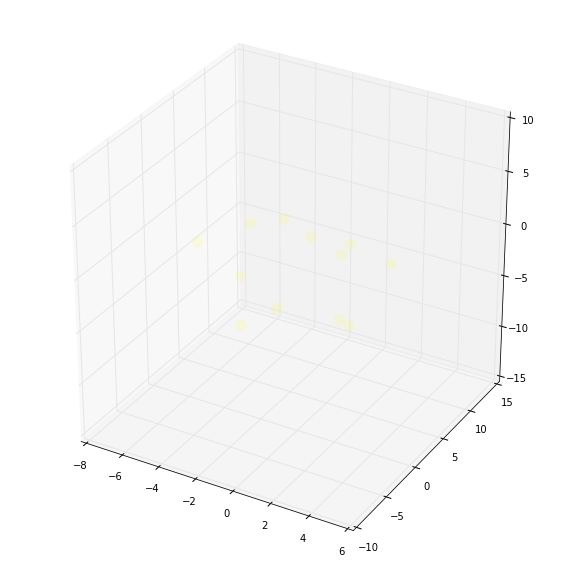

In [59]:
plot_centroid_means_and_covars_3d(instance_centroids_deviations_allstructures_outlier_removed)

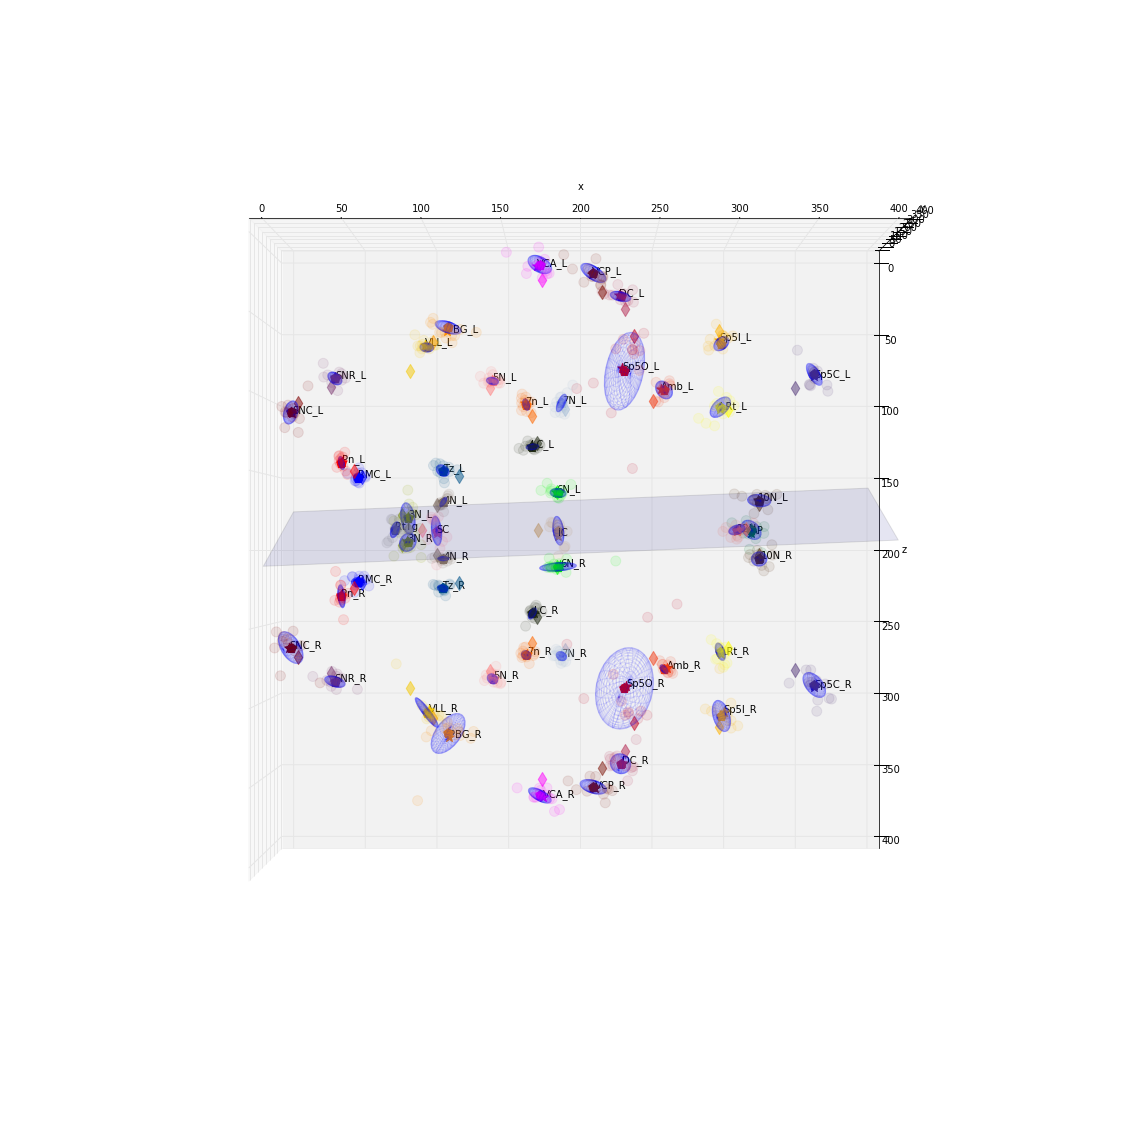

In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot mid-sagittal plane
ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#            color=(0,0,0), marker='^', s=200)

for name_s in all_known_structures_sided:

#     centroids = np.array(instance_centroids_rel2fixed[name_s])
#     ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                marker='o', s=100, alpha=.1)

    c = canonical_locations_rel2fixed[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='d', s=100, alpha=.5)
    
    c = new_mean_centroids_rel2atlas_allstructures[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='*', s=100, alpha=1)
    ax.text(c[0], c[1], c[2], name_s)
    
    c = updated_canonical_locations_rel2atlas[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='p', s=100, alpha=1)

    # Plot uncerntainty ellipsoids
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
    y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
    z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(u)):
        for j in range(len(v)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     ax.plot_surface(x, y, z, color='b')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.1)

    
    centroids = np.array([c for st, c in adjusted_structure_centroids_rel2atlas[name_s].iteritems()
                         if st not in outliers_allstructures[name_s]])
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='o', s=100, alpha=.1)
    
    if len(outliers_allstructures[name_s]) > 0:
        centroids = np.array([c for st, c in adjusted_structure_centroids_rel2atlas[name_s].iteritems()
                             if st in outliers_allstructures[name_s]])
        ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
                   color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
                   marker='^', s=100, alpha=.1)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_axis_off()
ax.set_xlim3d([0, 400]);
ax.set_ylim3d([0, 400]);
ax.set_zlim3d([0, 400]);
ax.view_init(azim = -90, elev = 180)
# ax.view_init(azim = -90, elev = -45)
ax.set_aspect(1.0)
plt.legend()
plt.title('');
plt.show()

In [18]:
# %matplotlib notebook

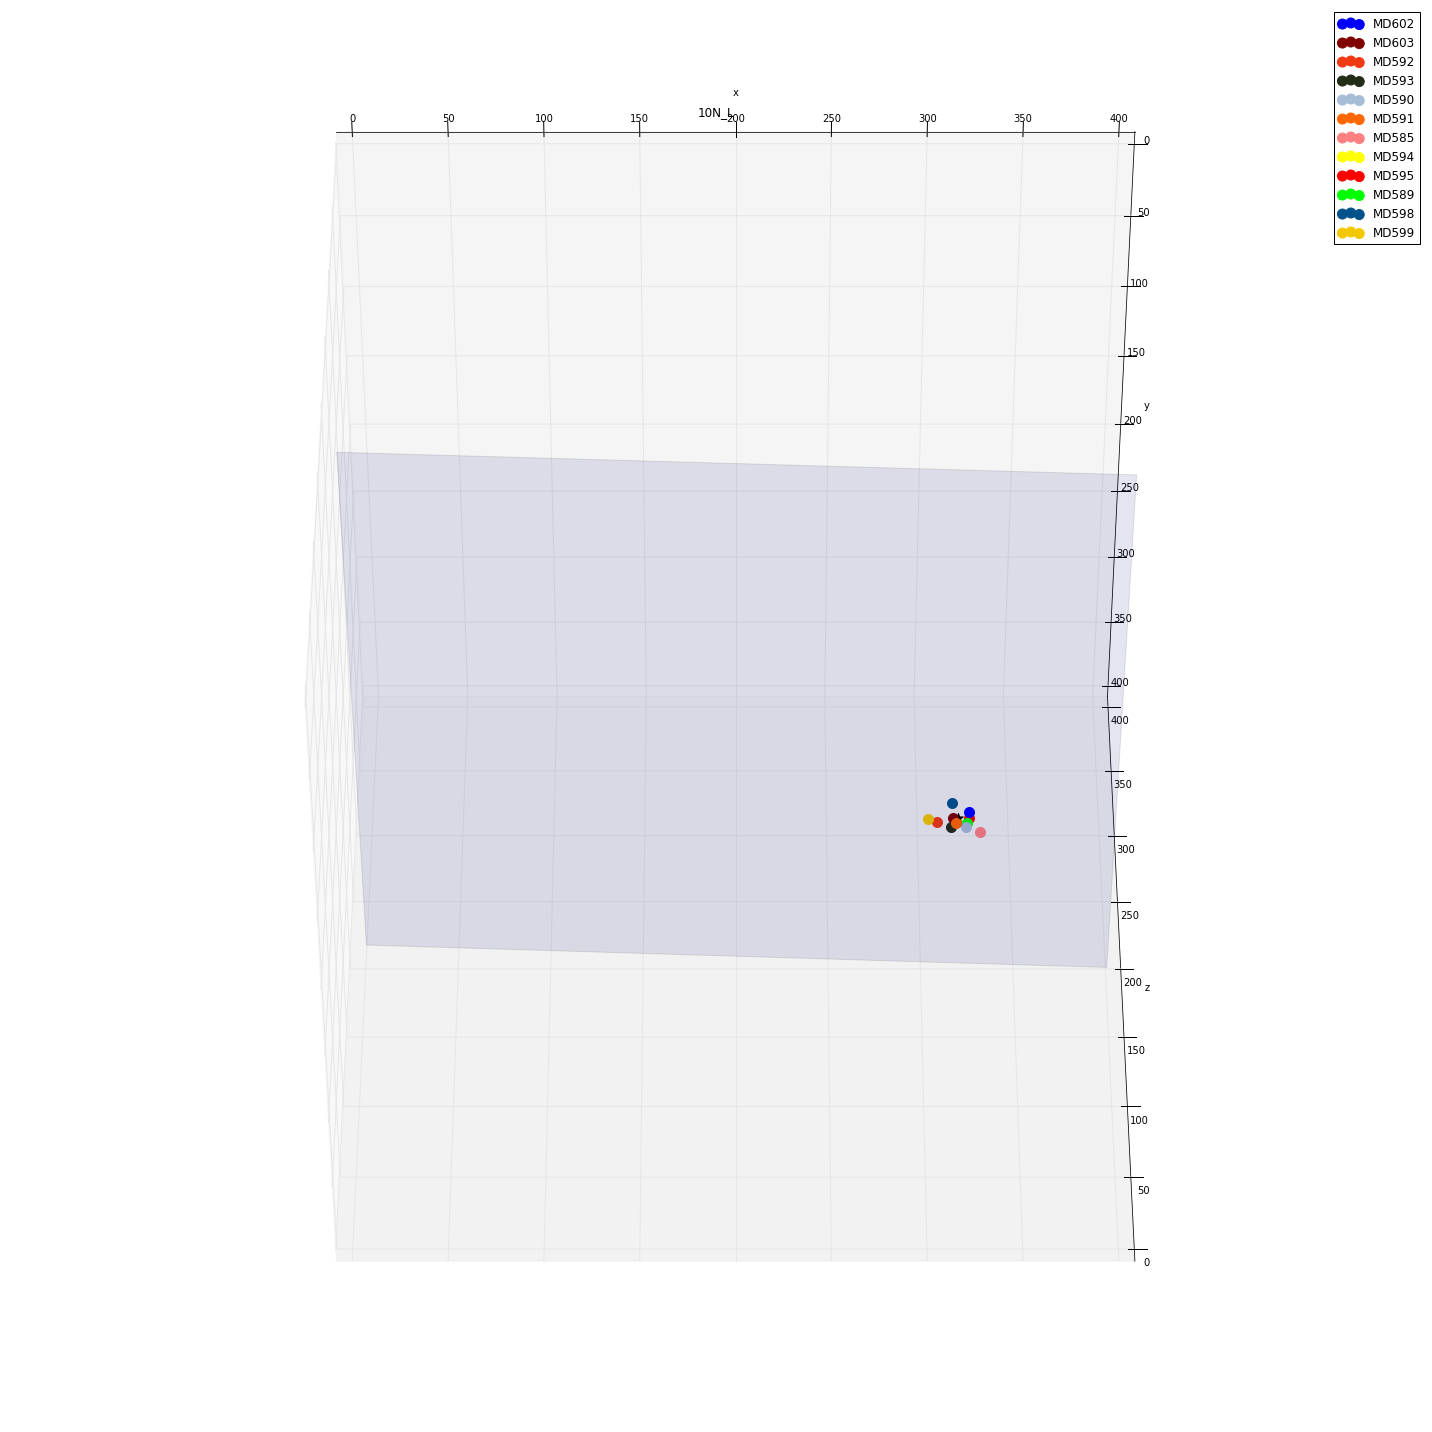

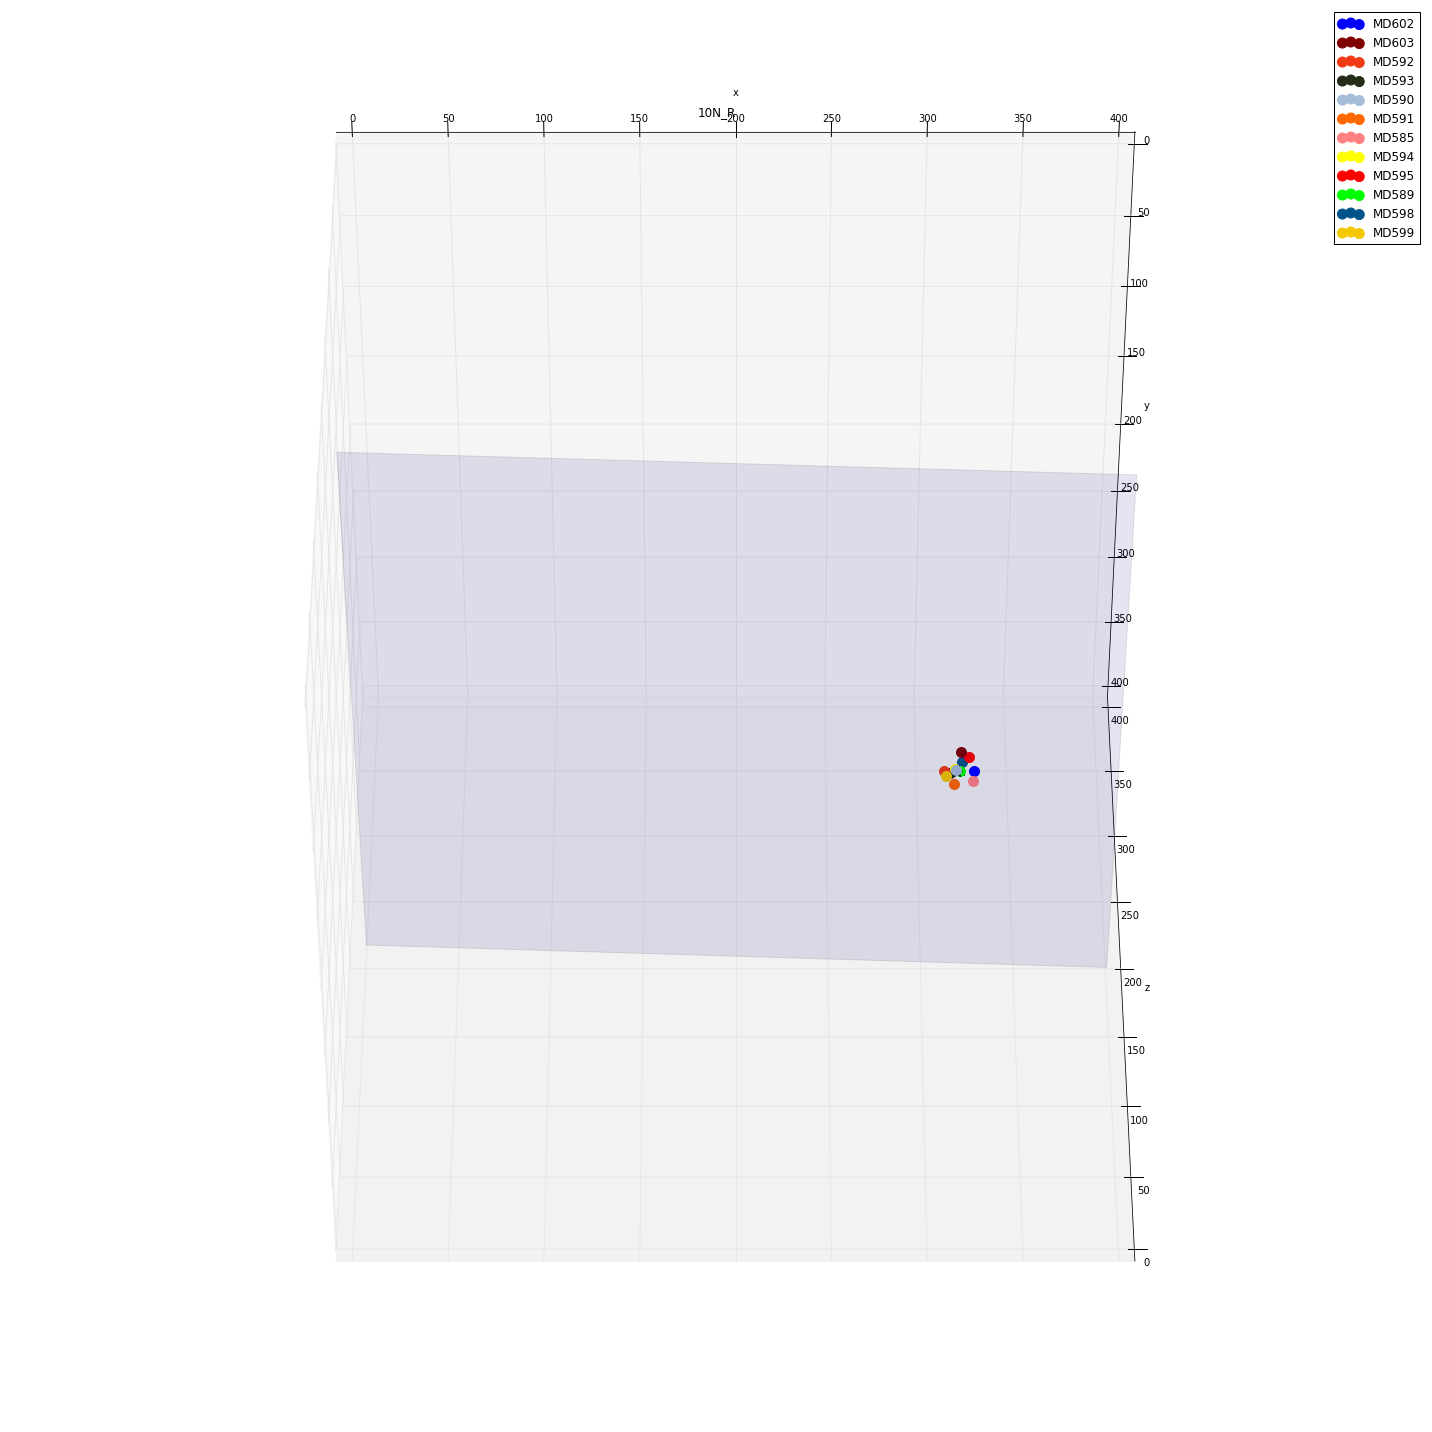

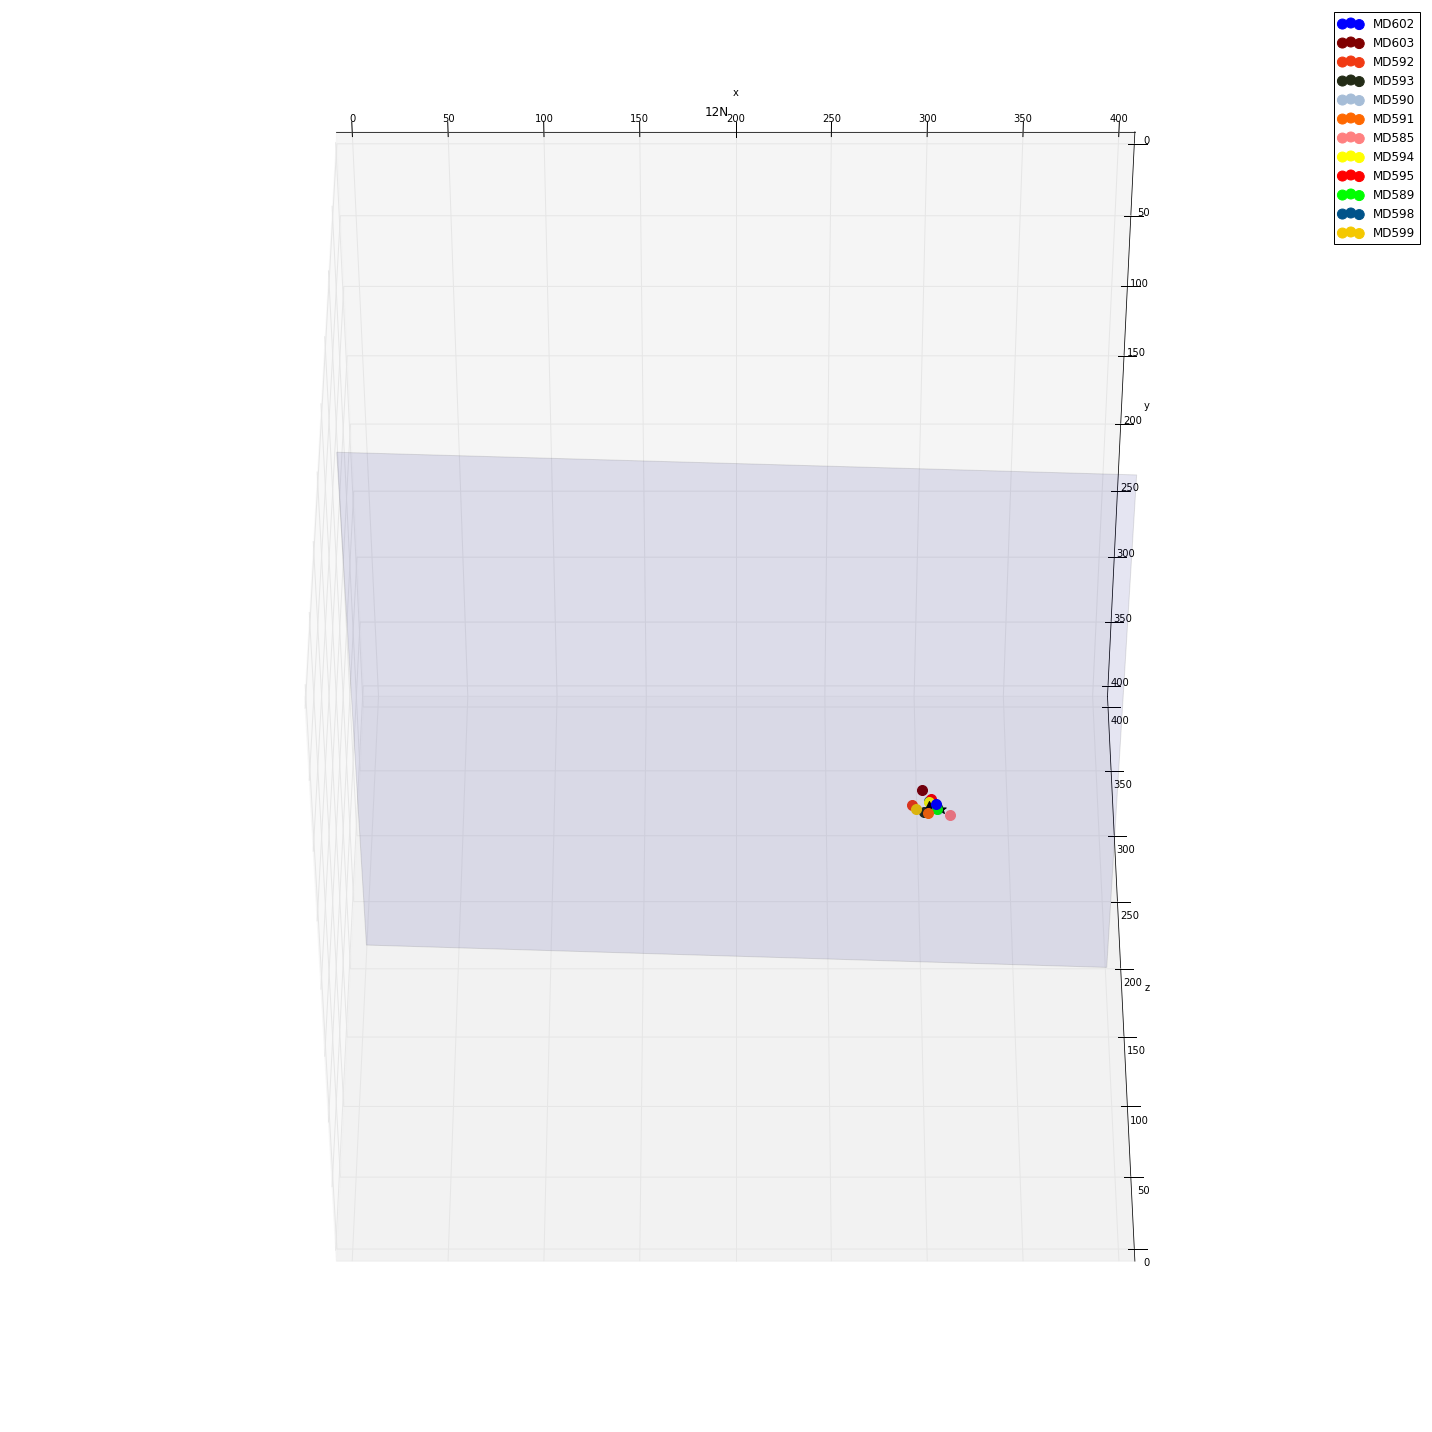

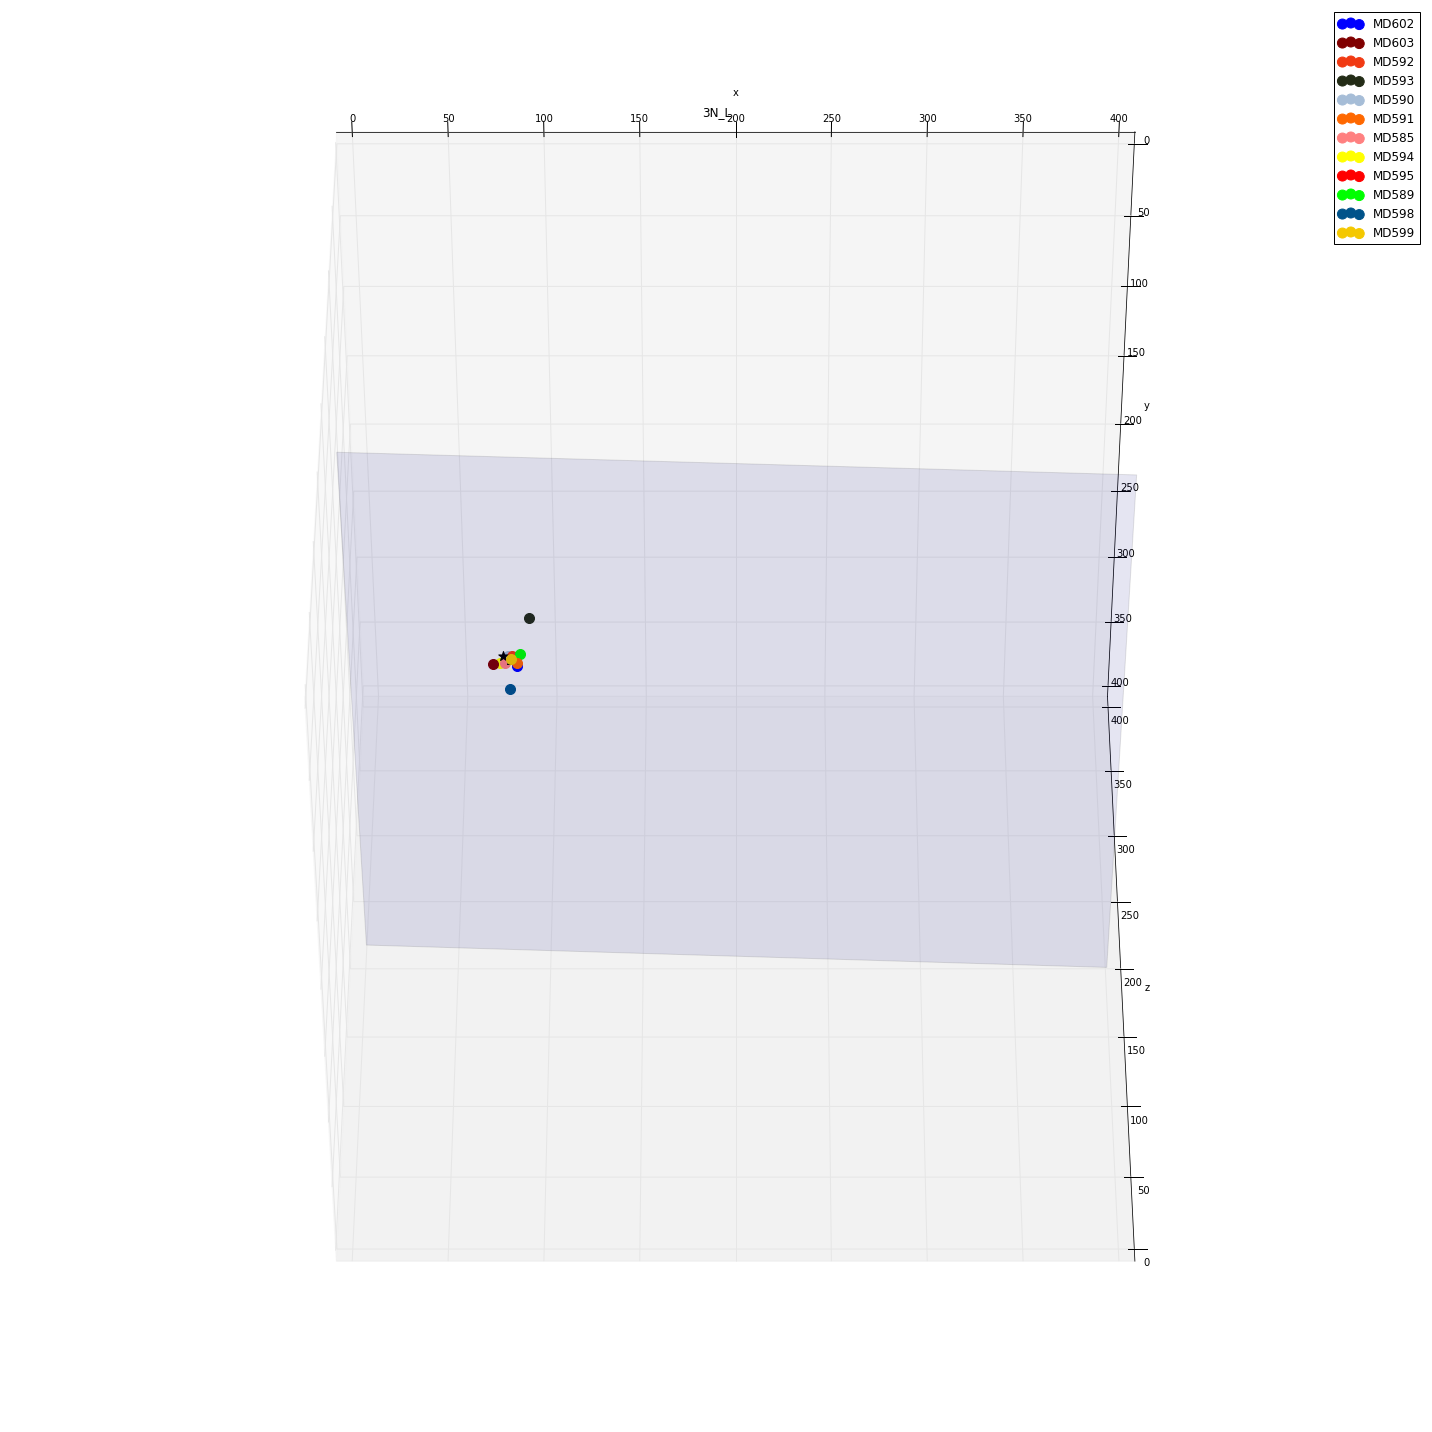

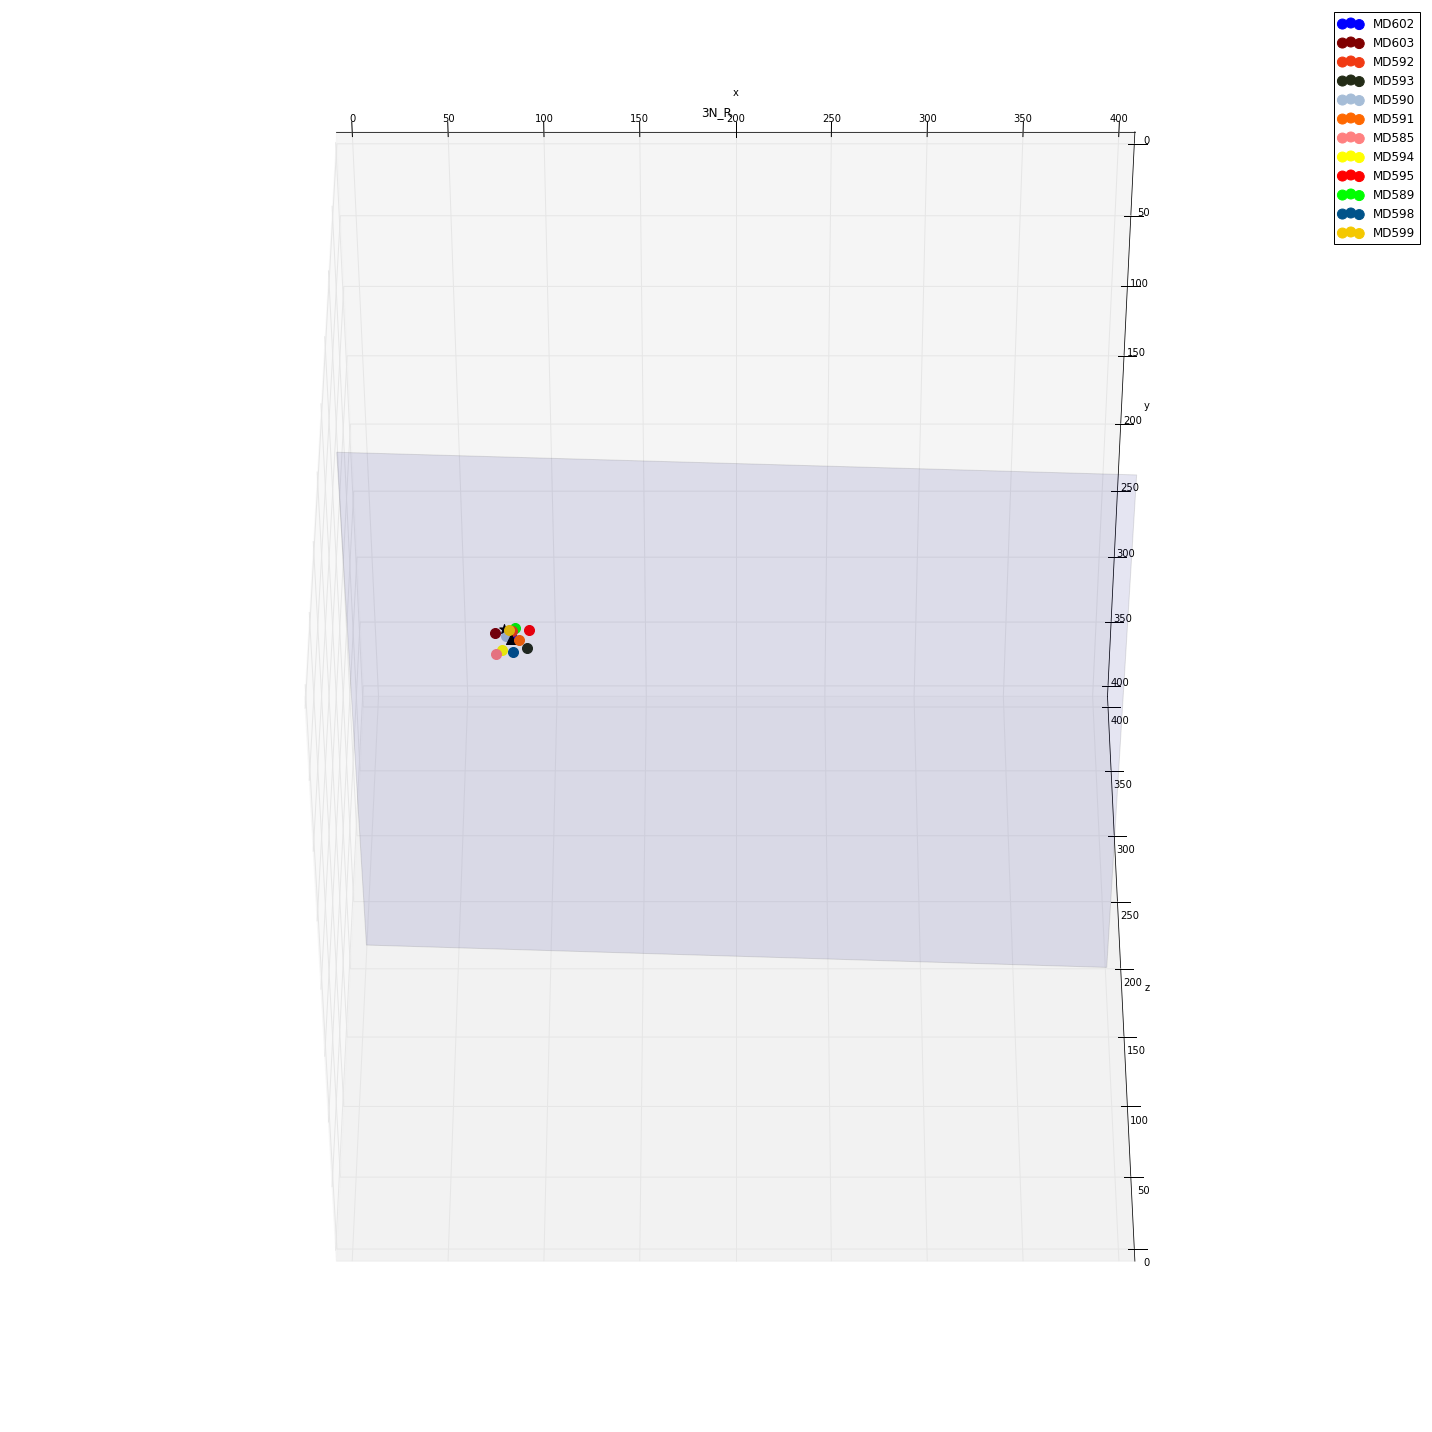

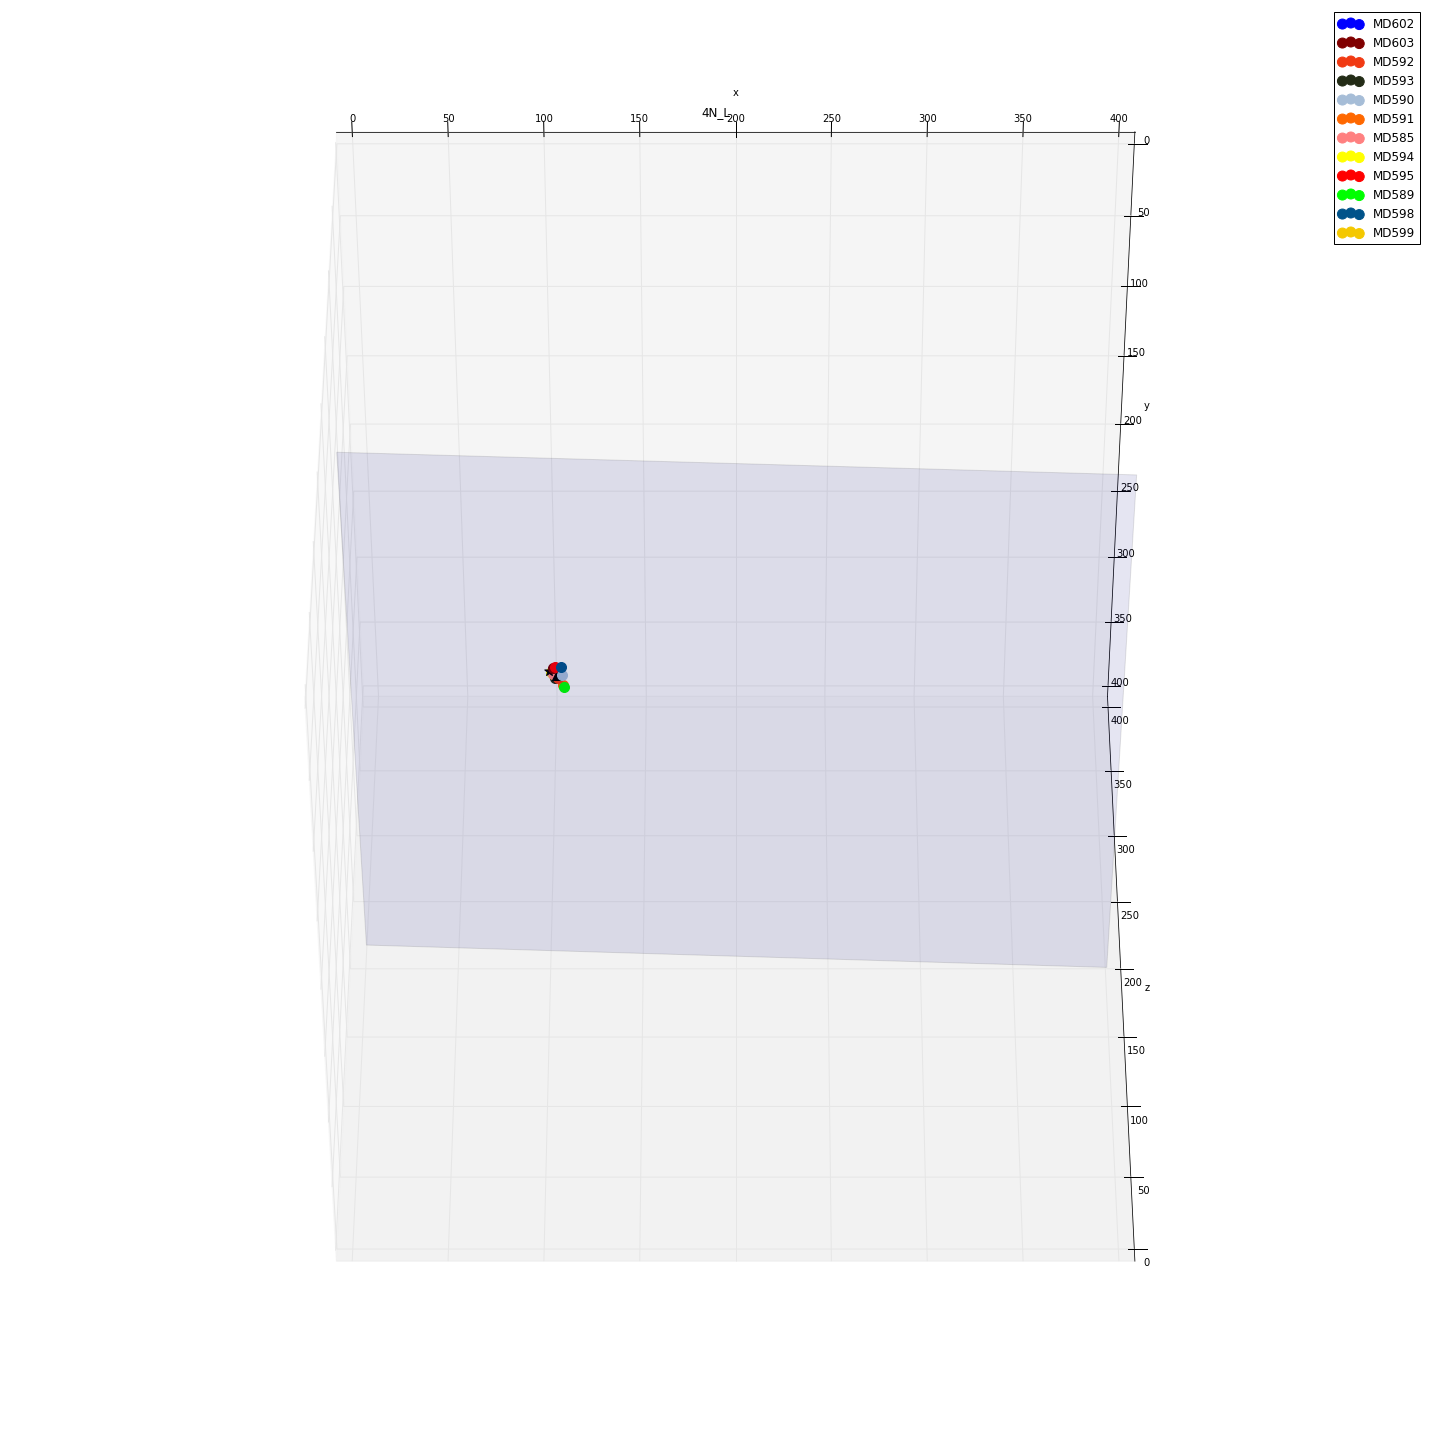

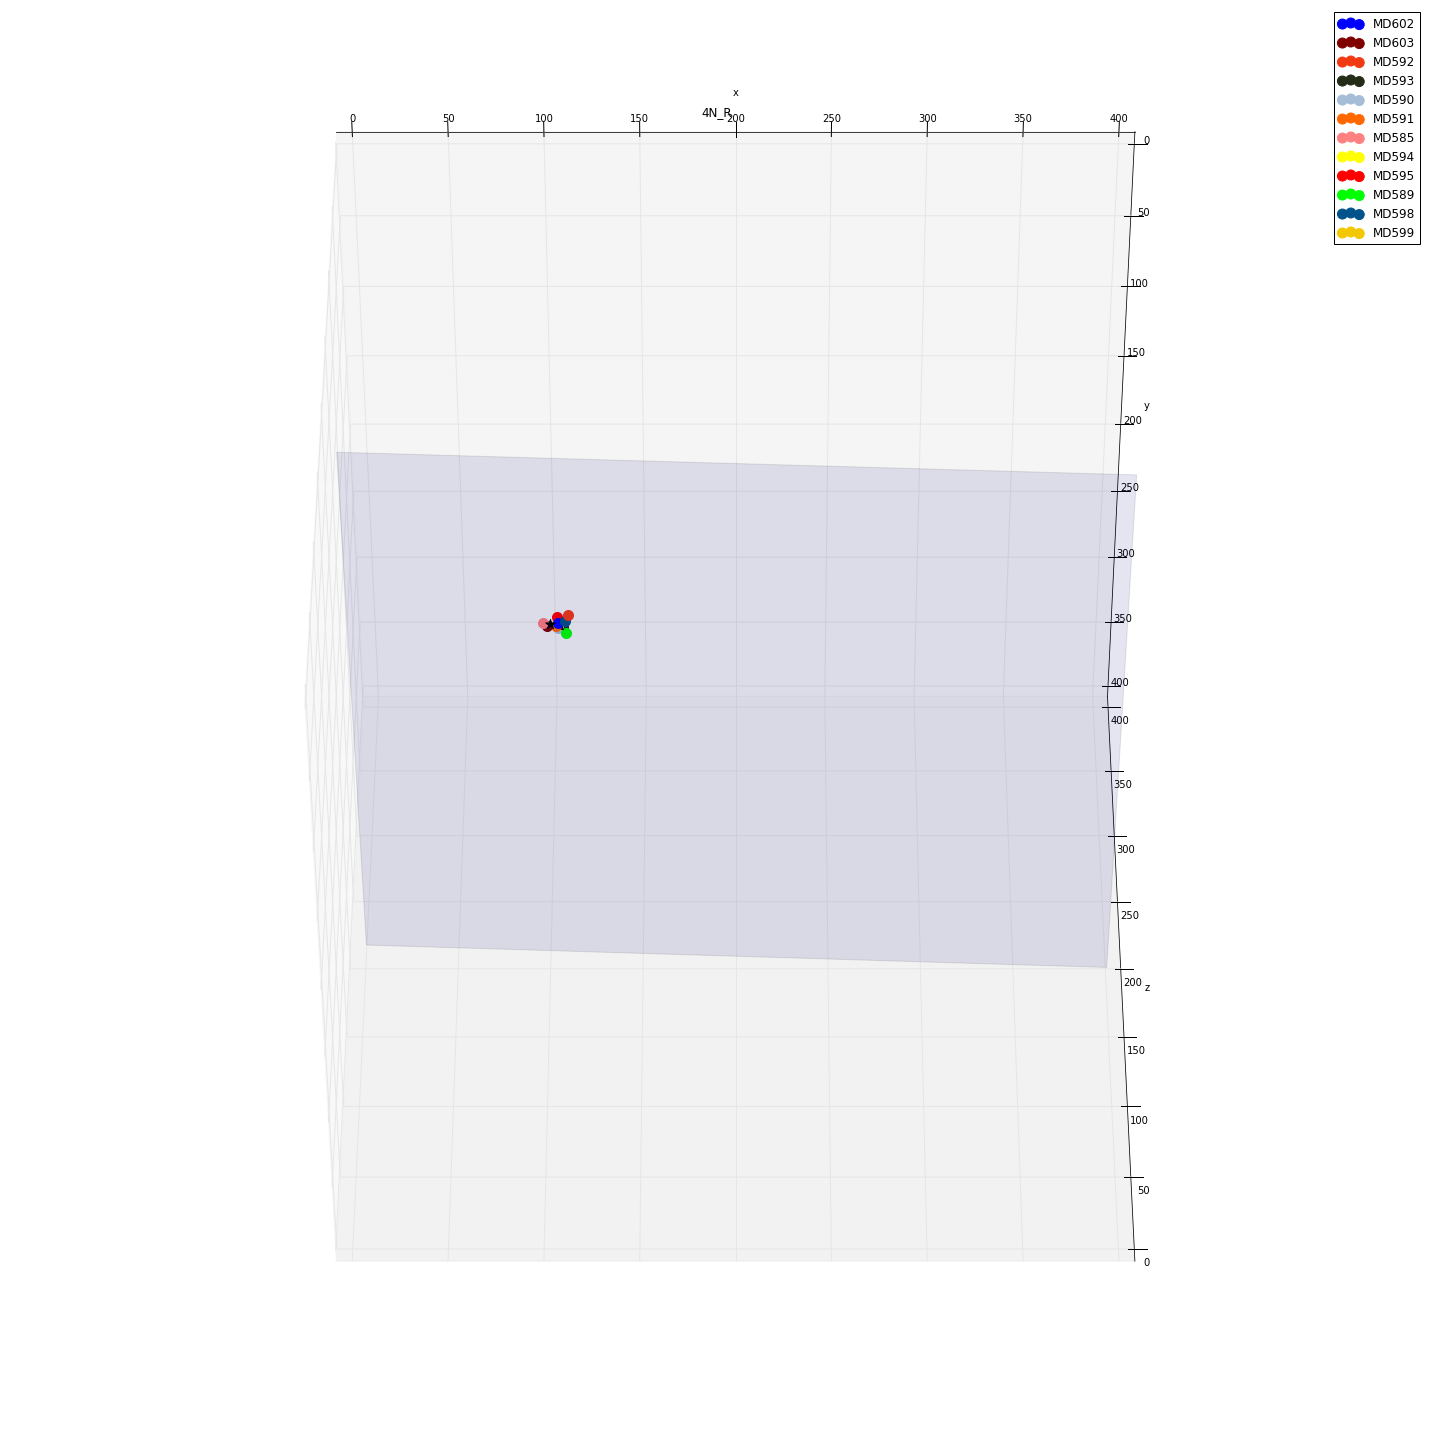

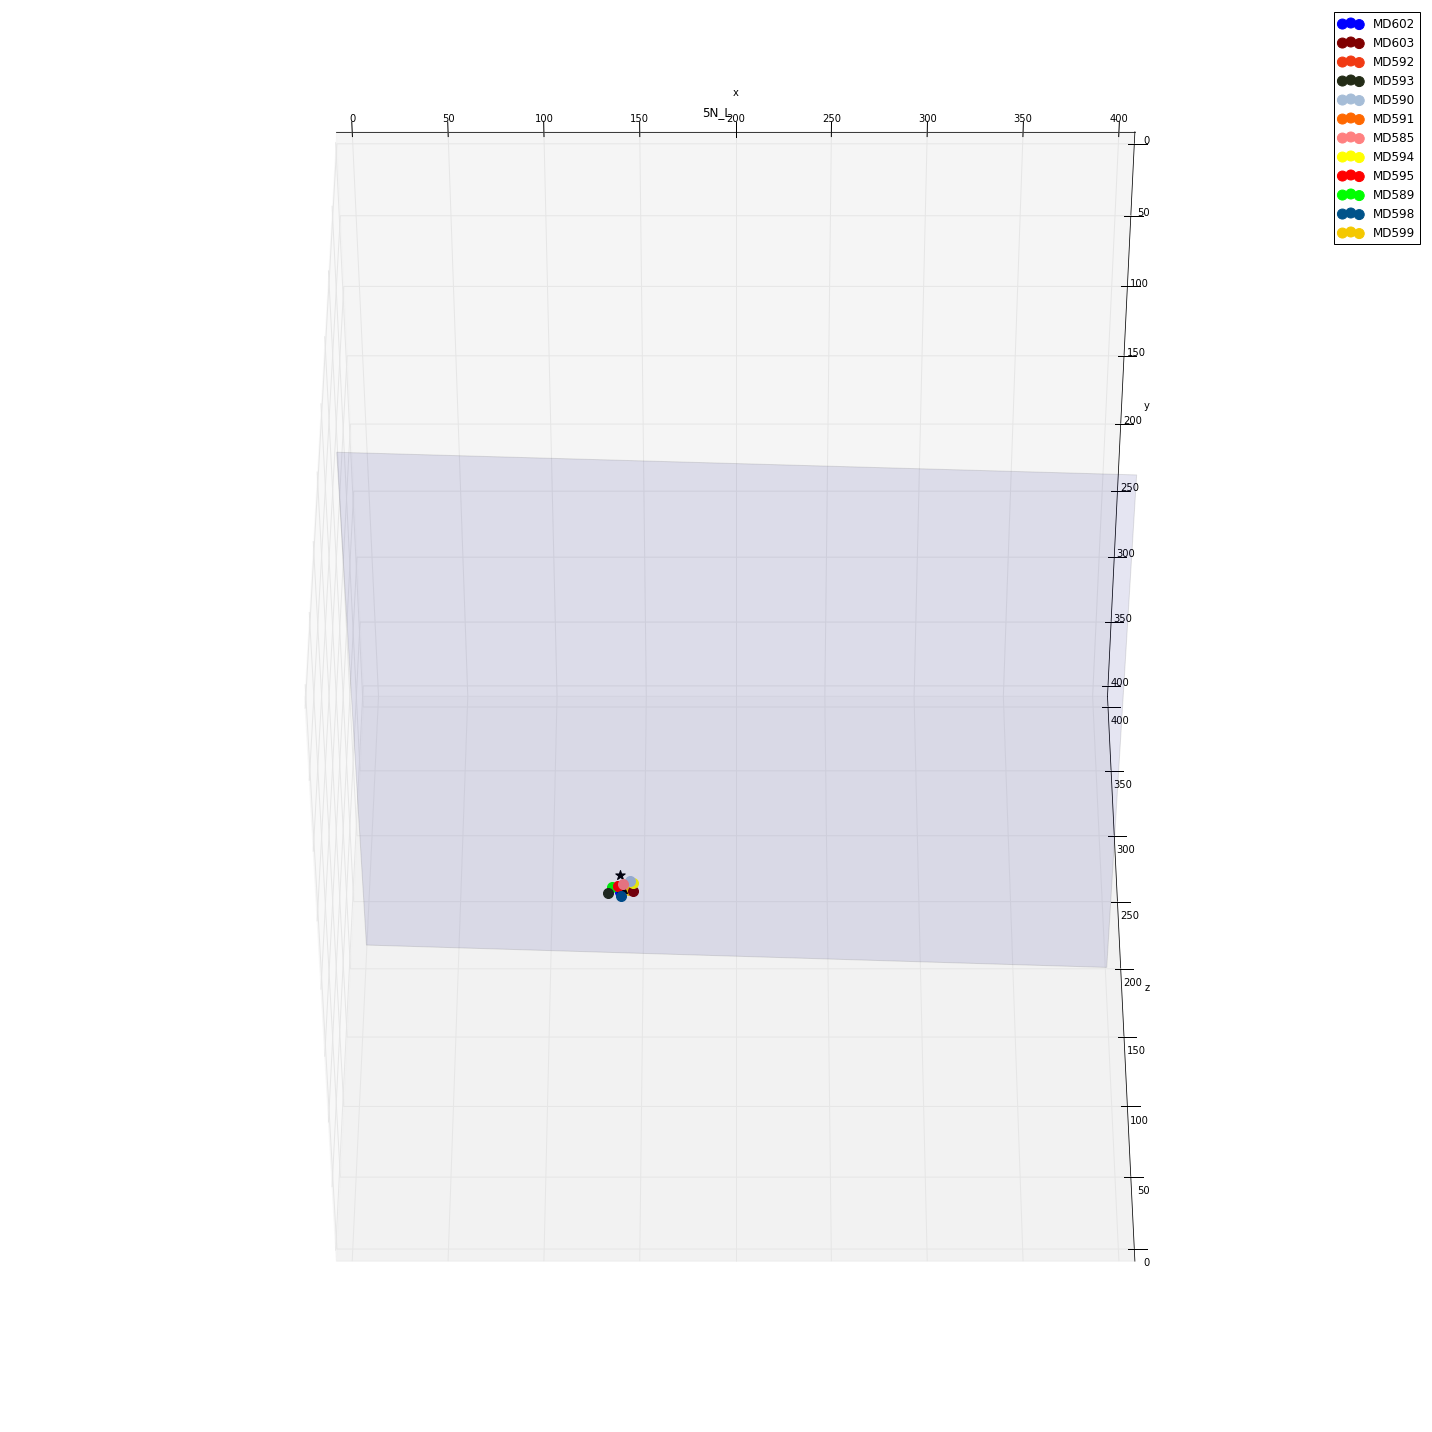

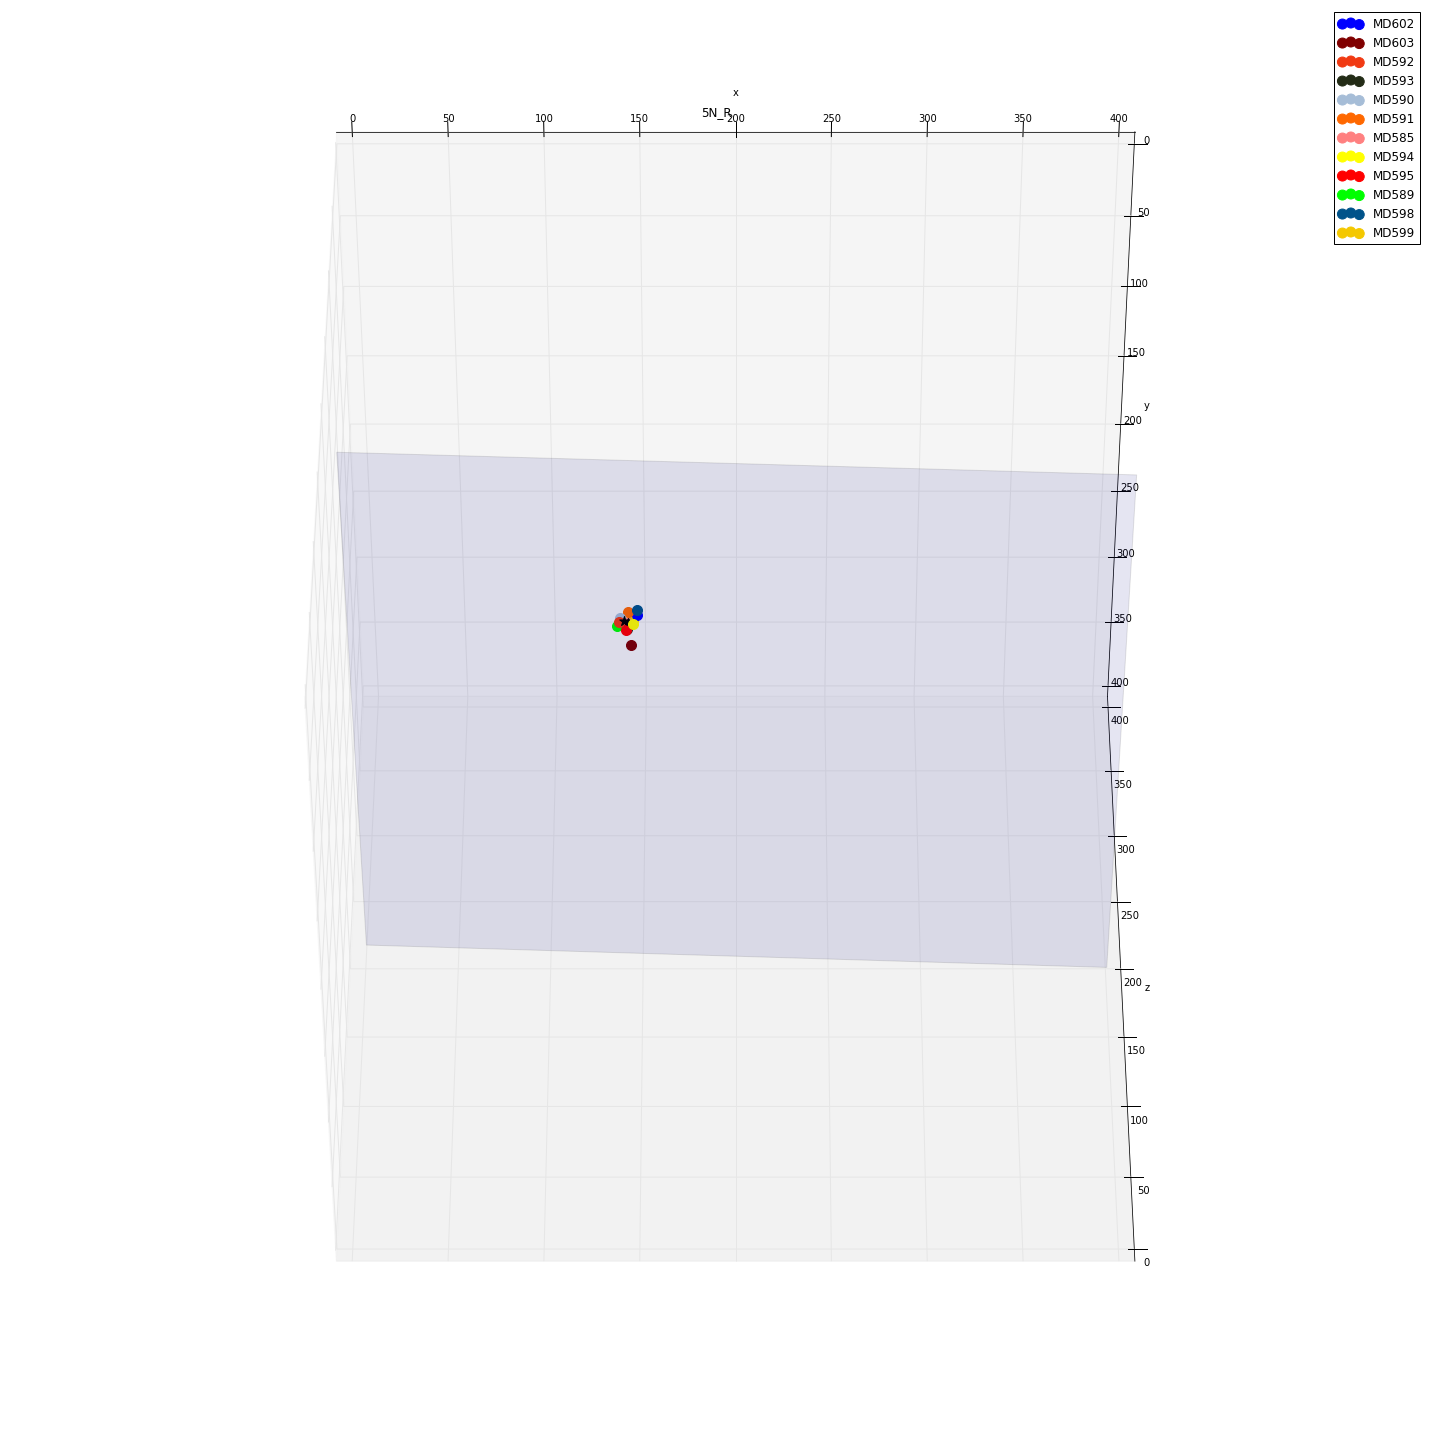

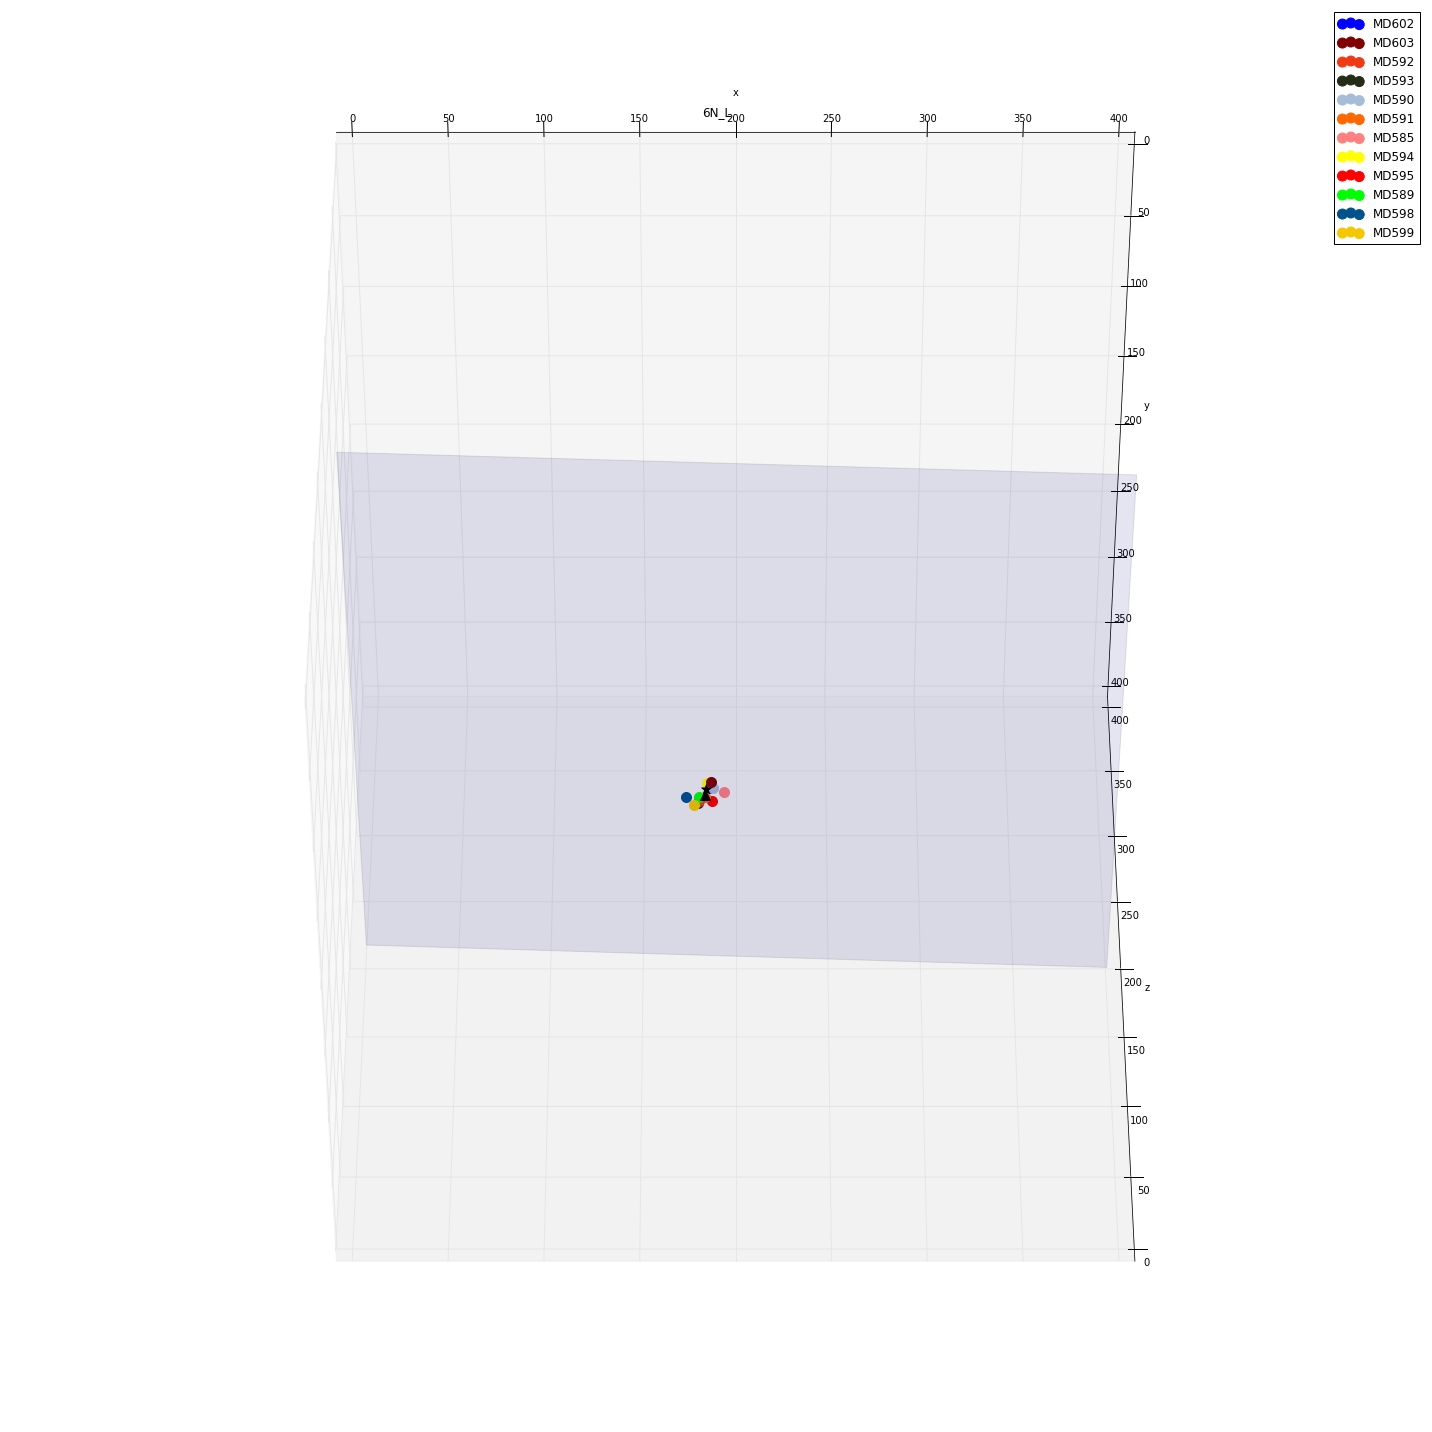

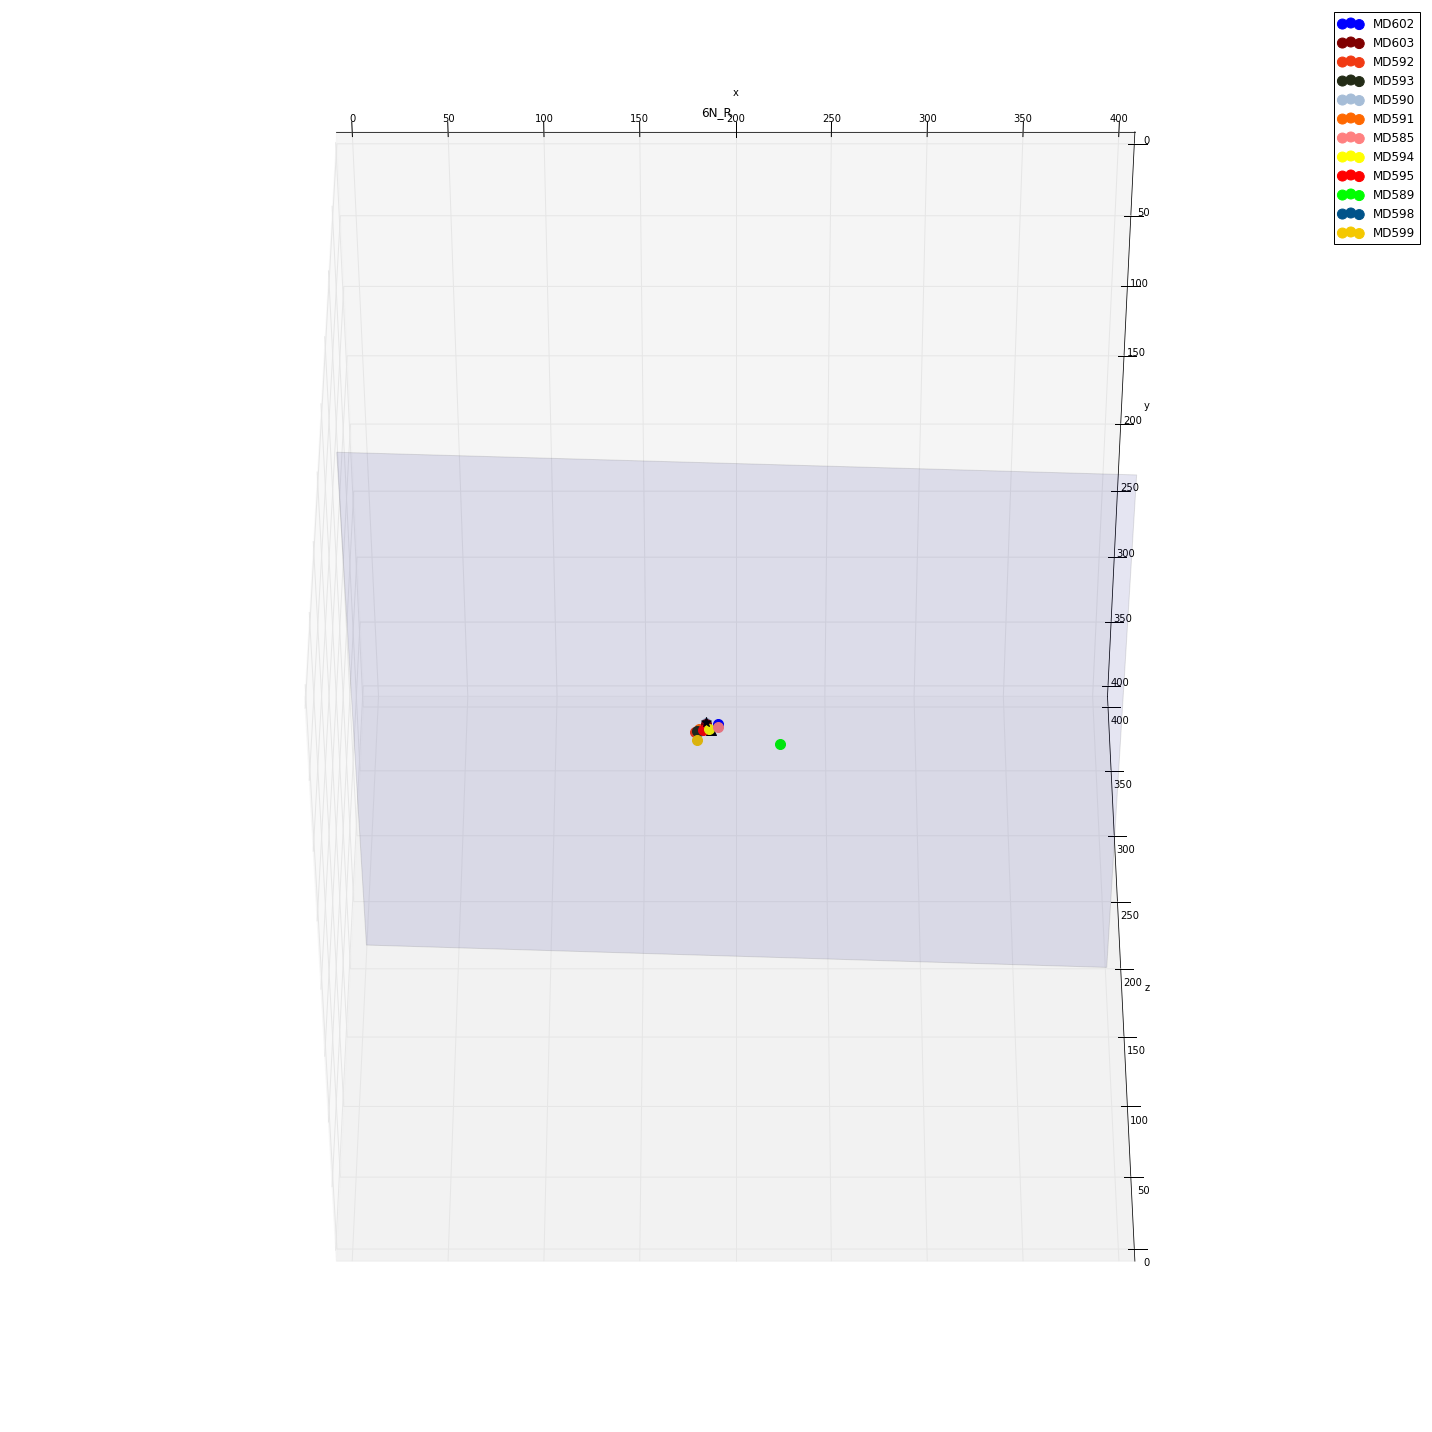

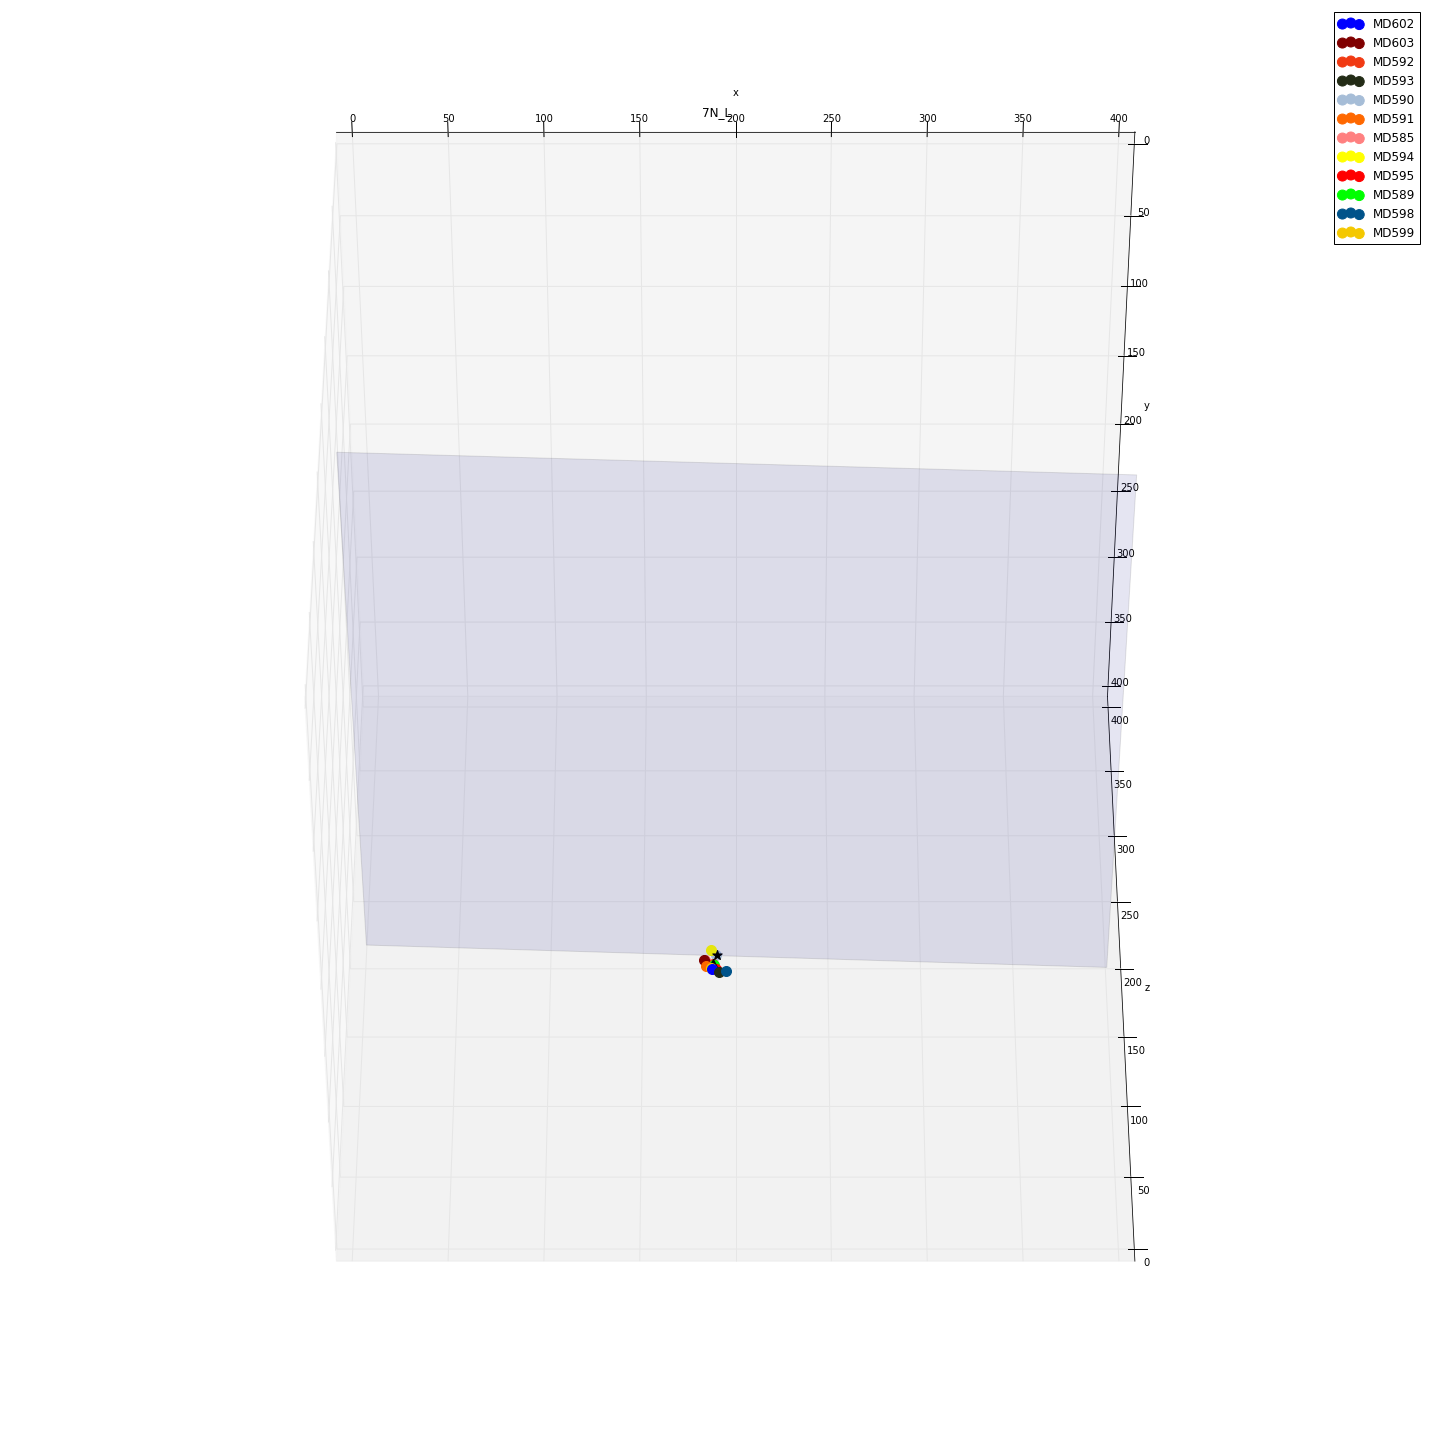

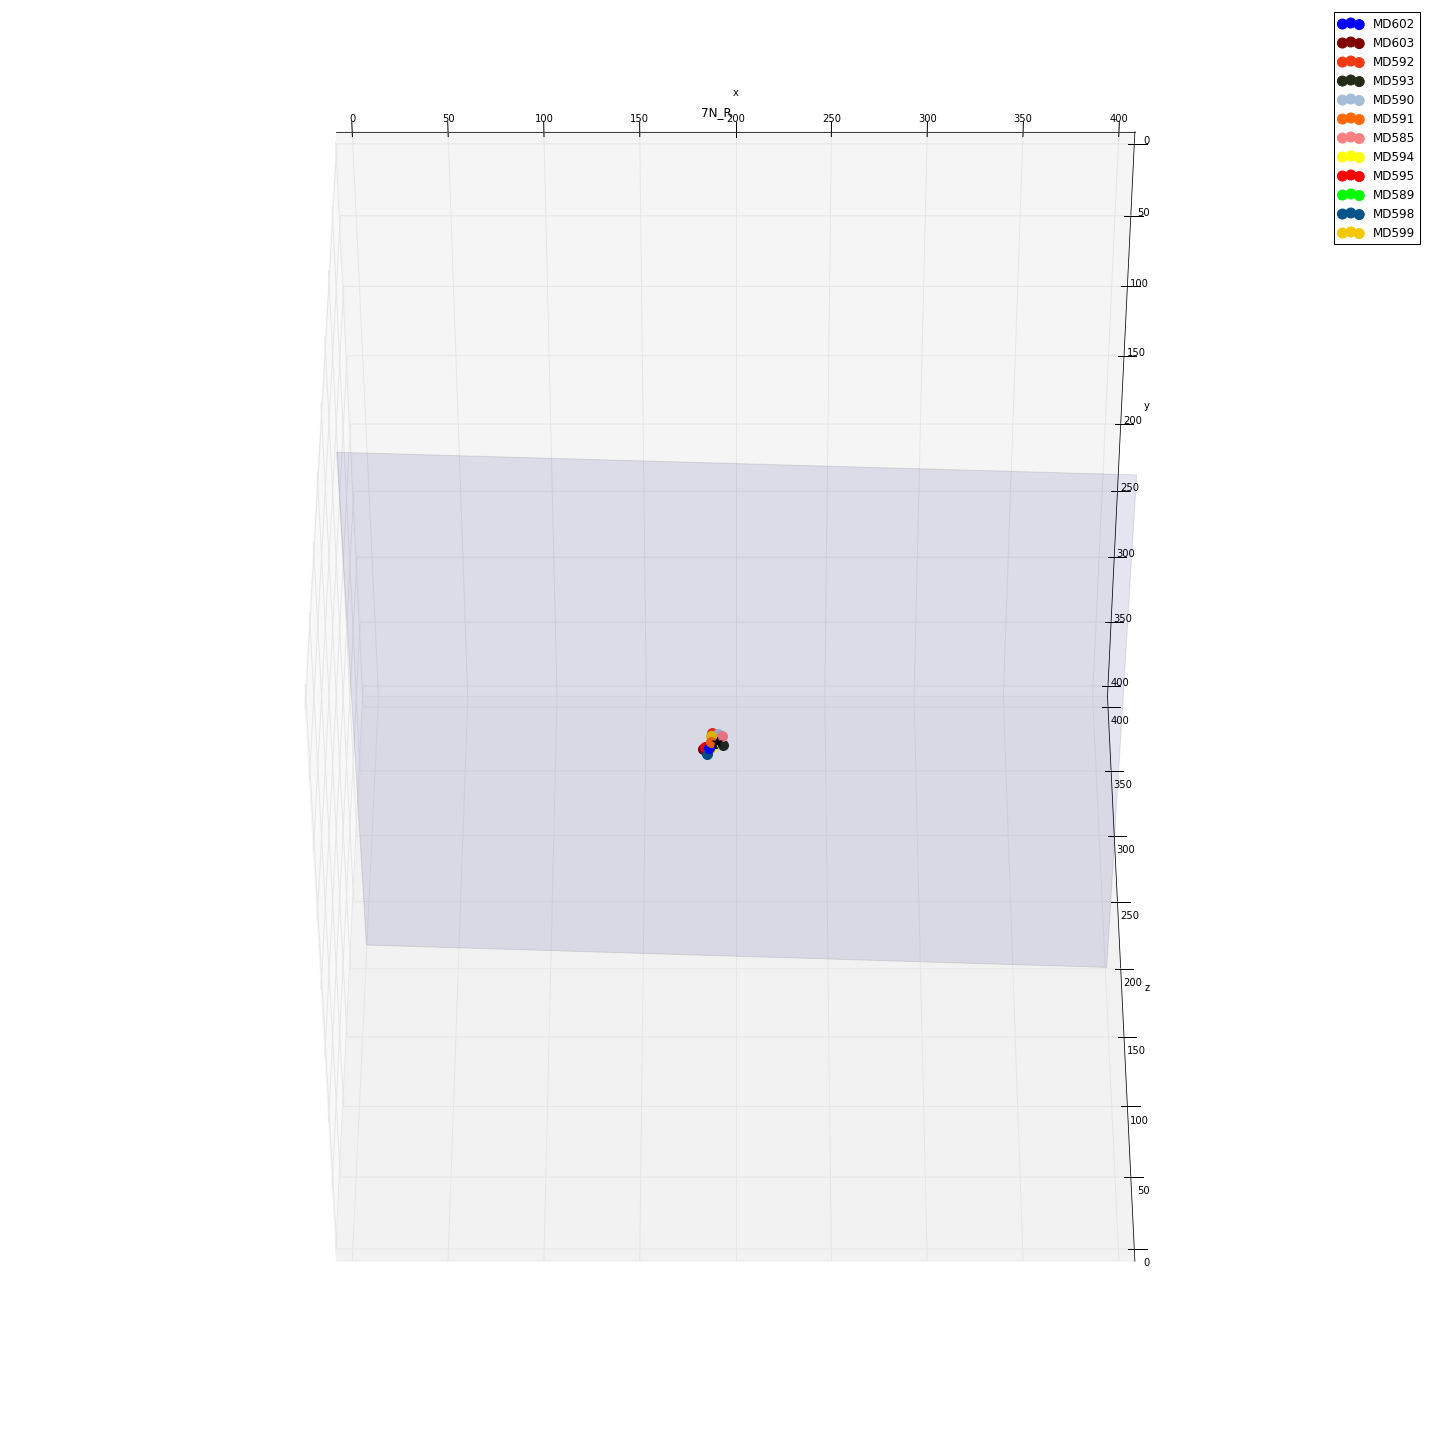

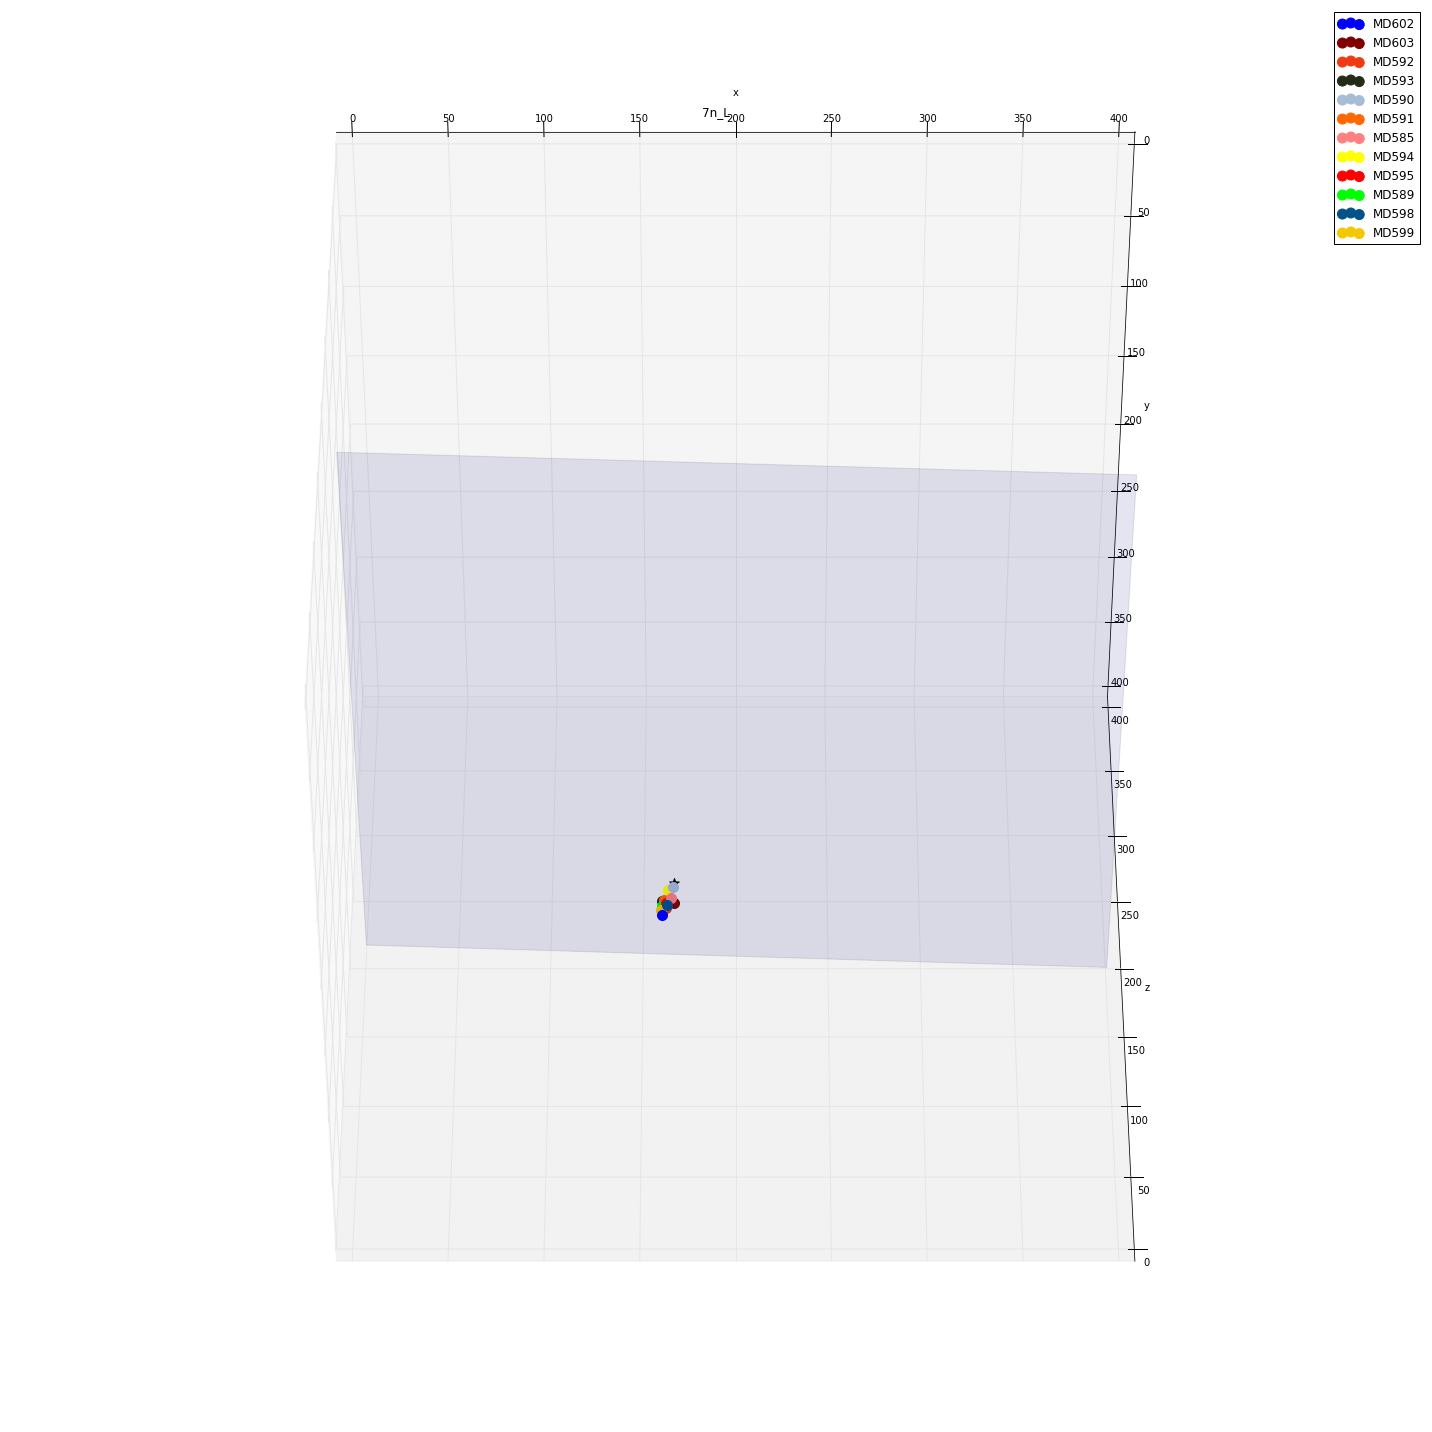

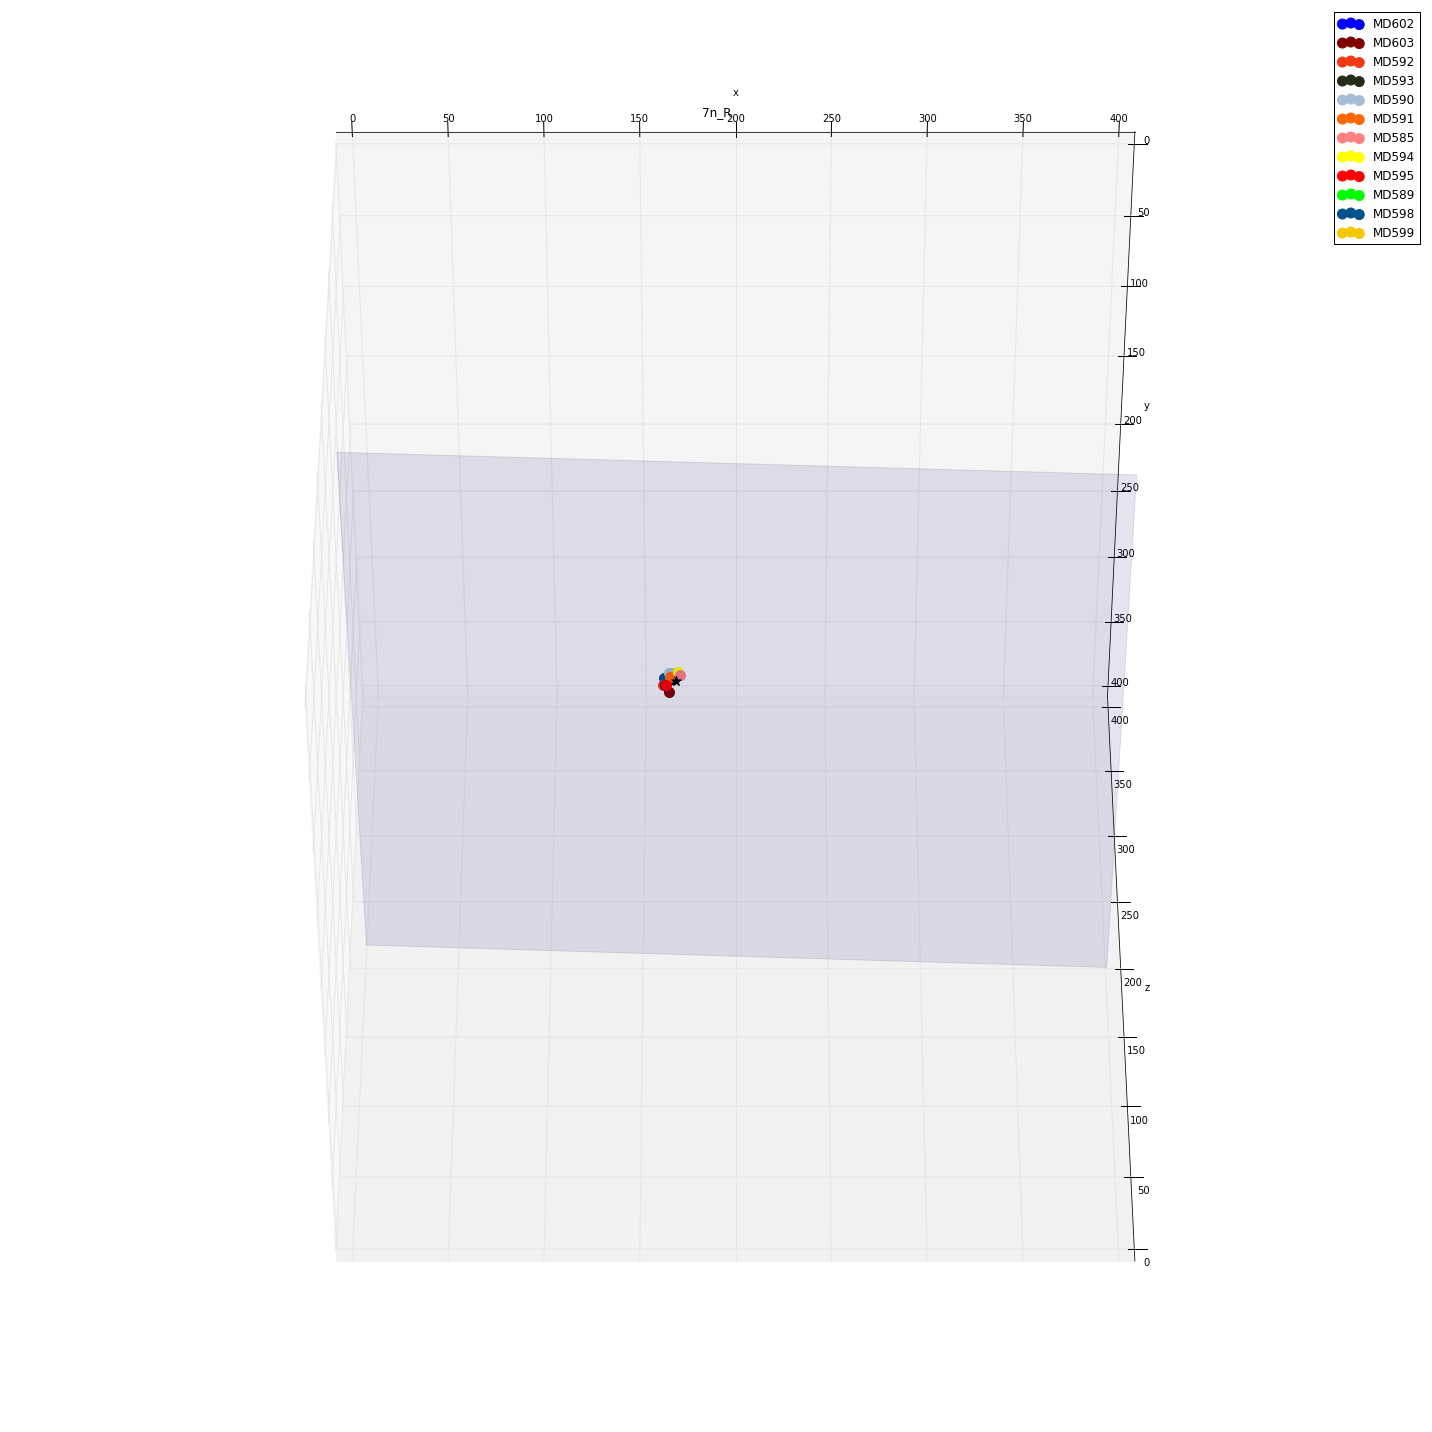

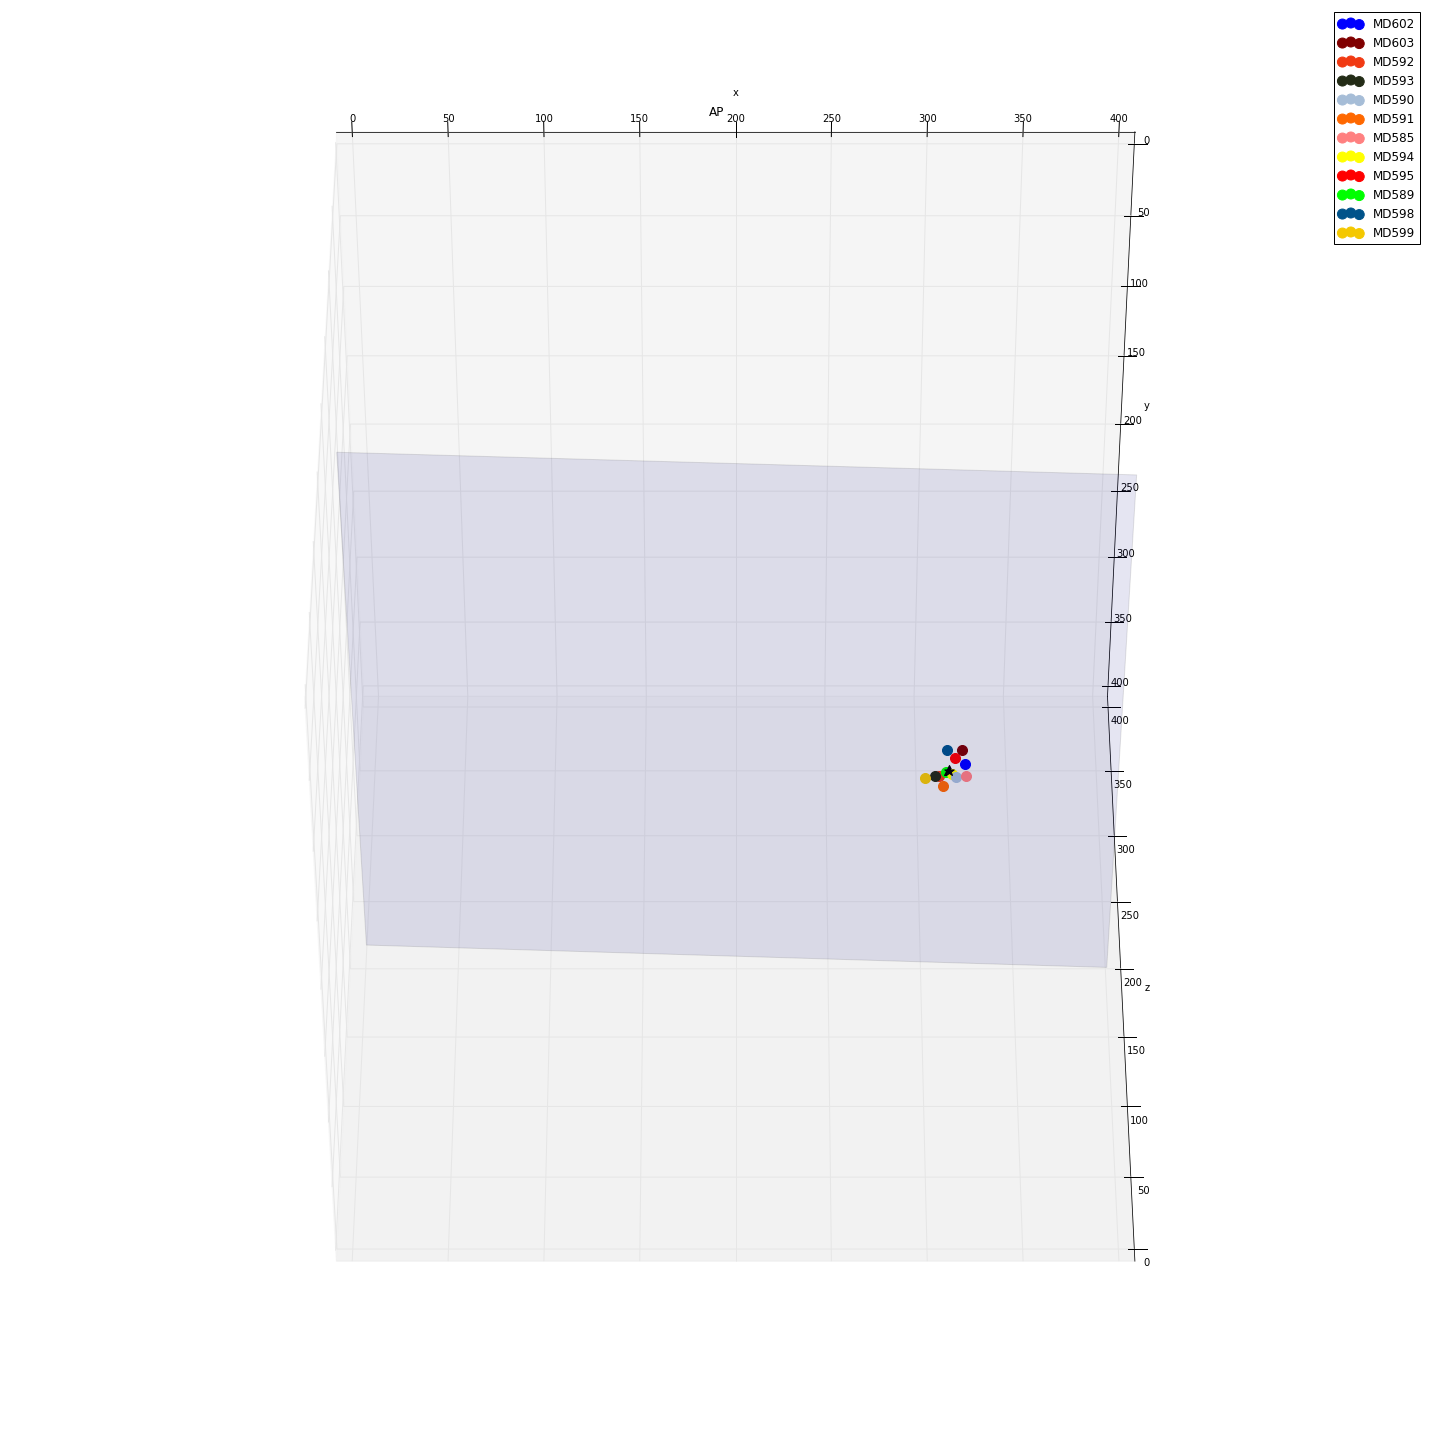

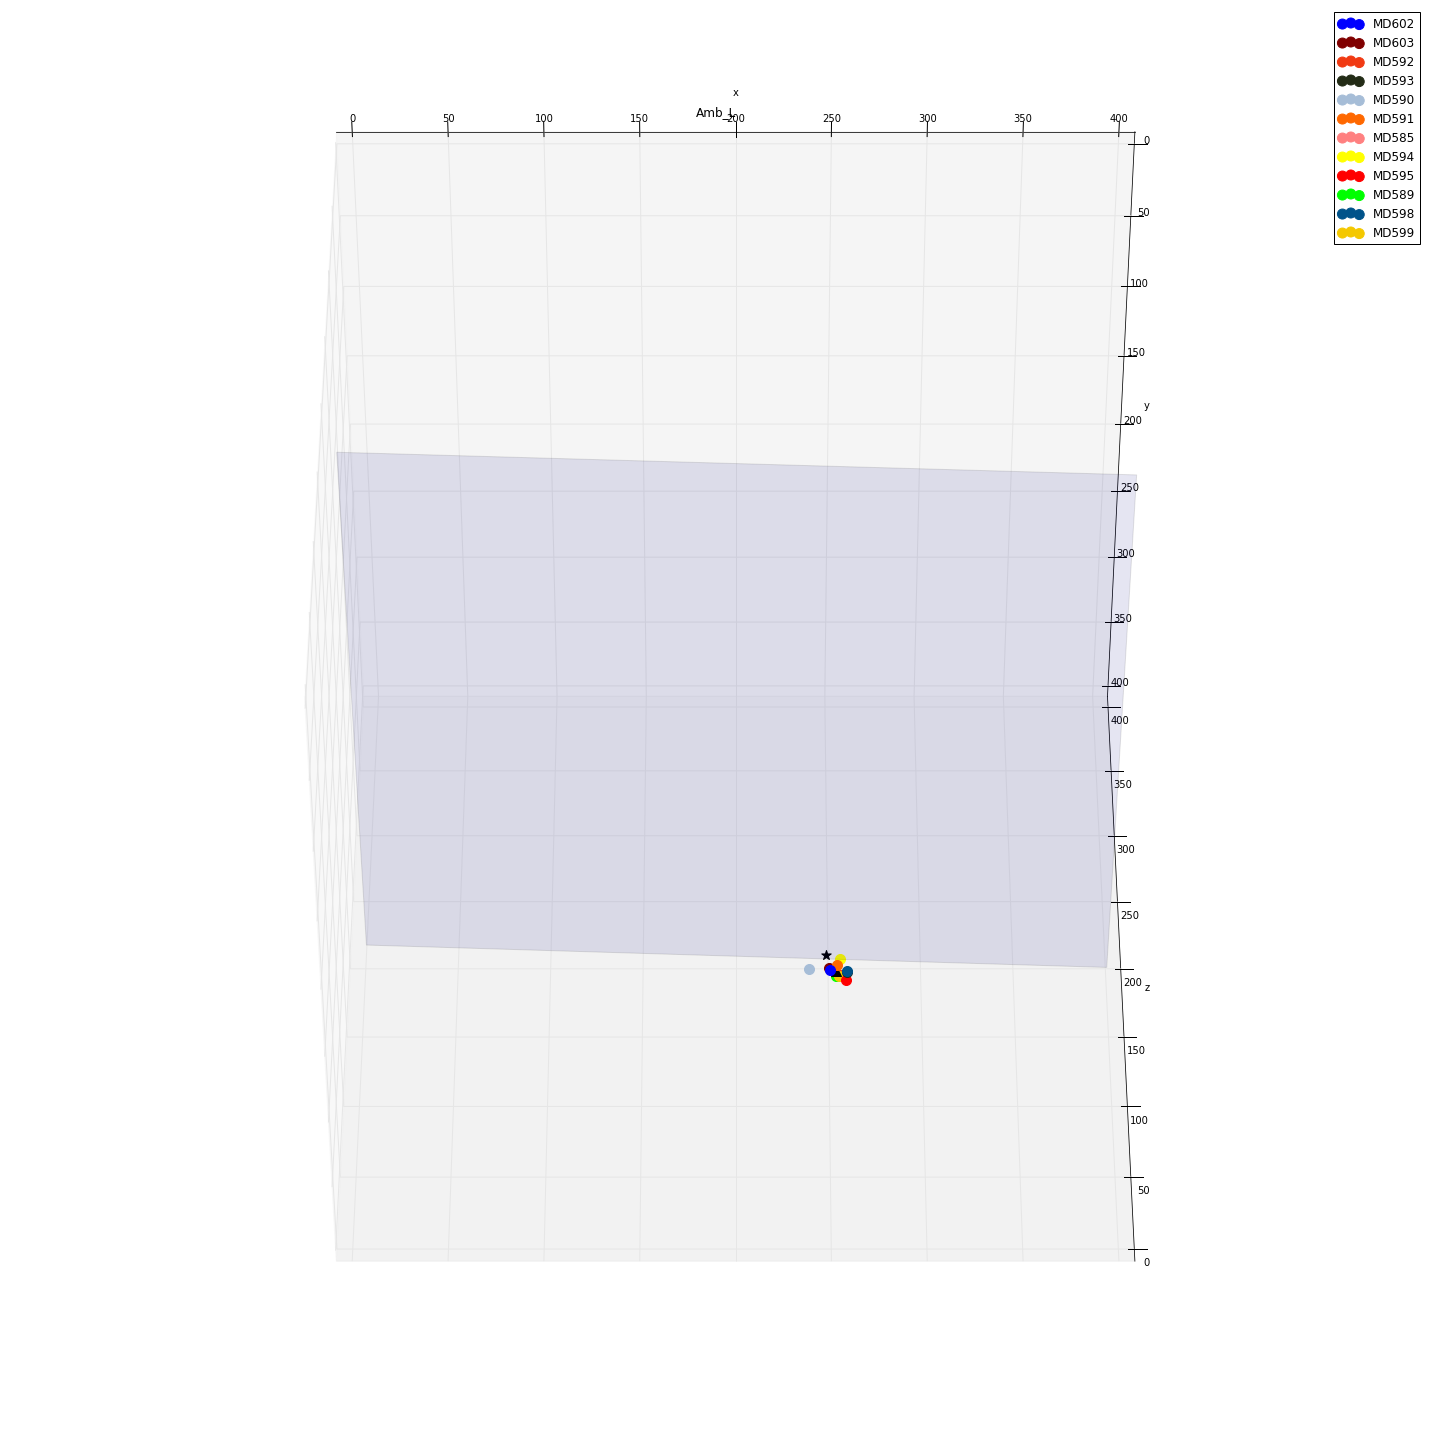

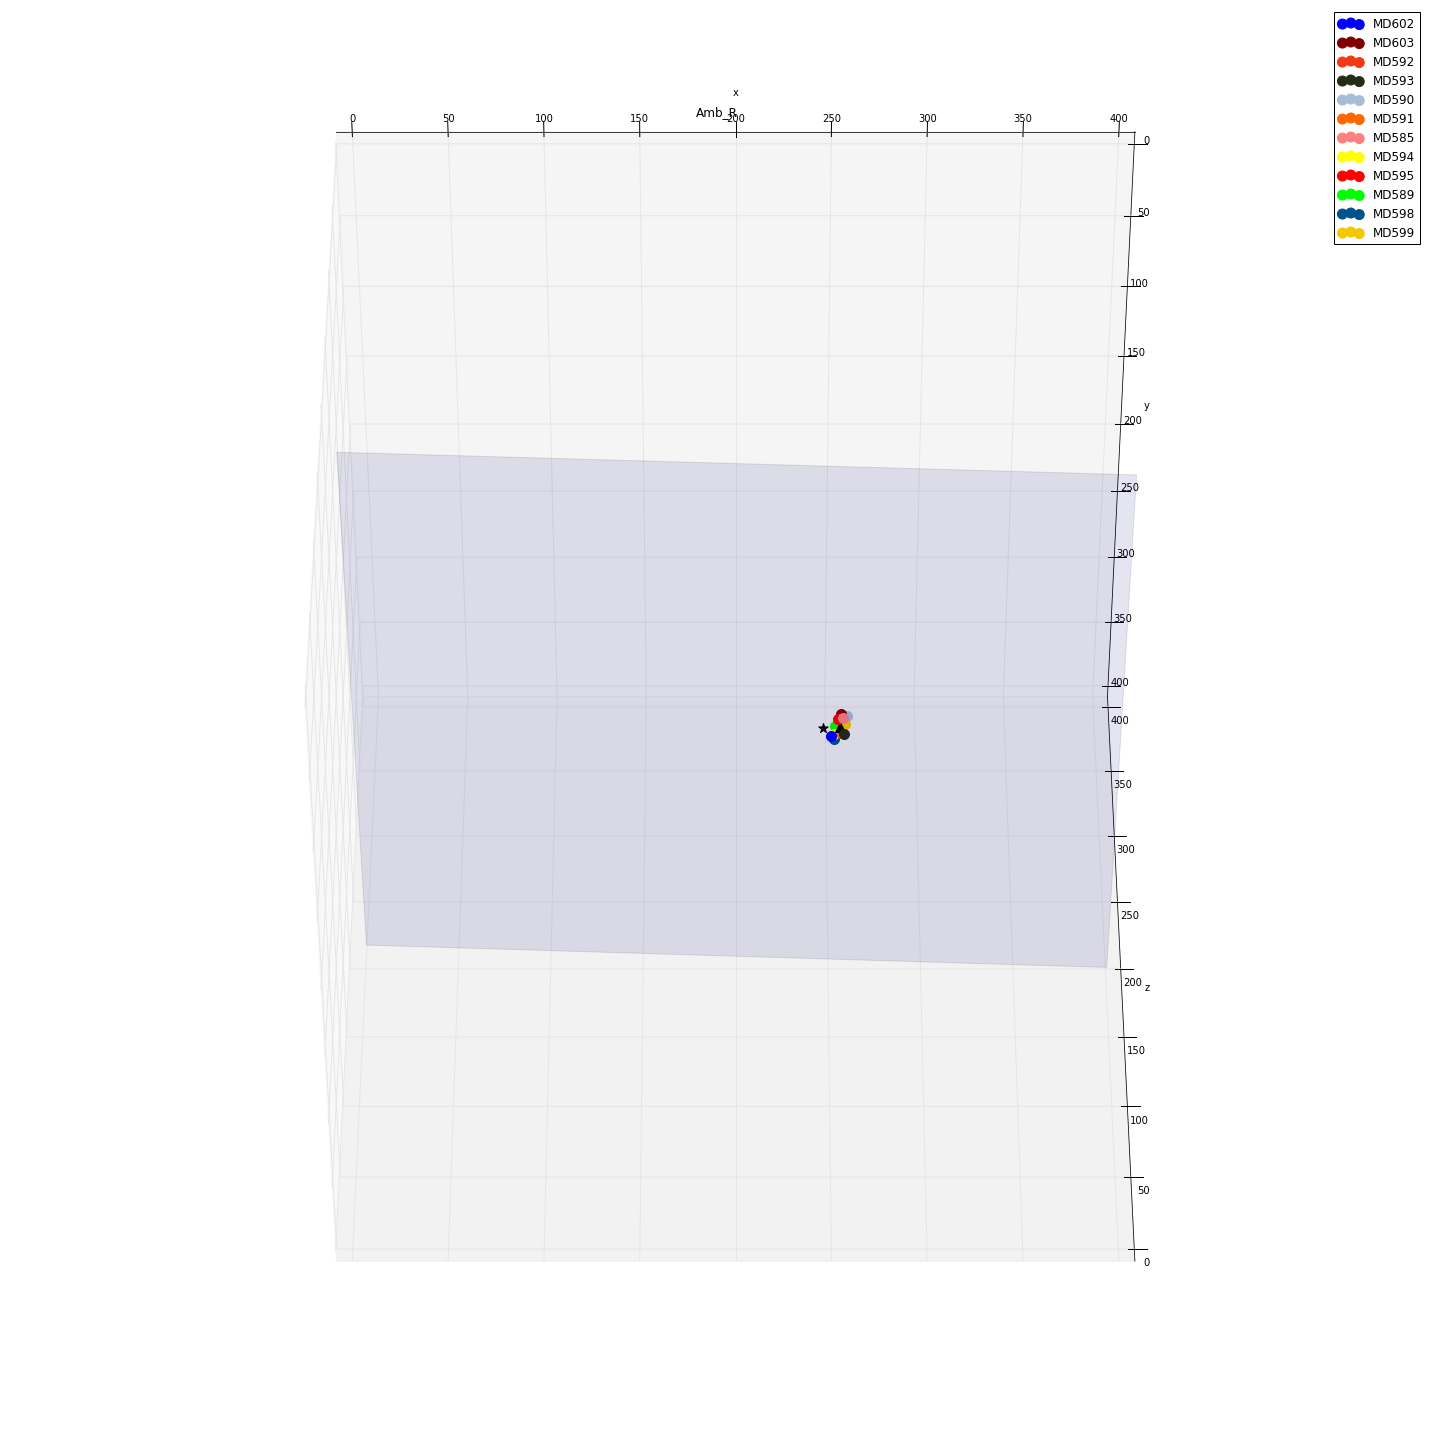

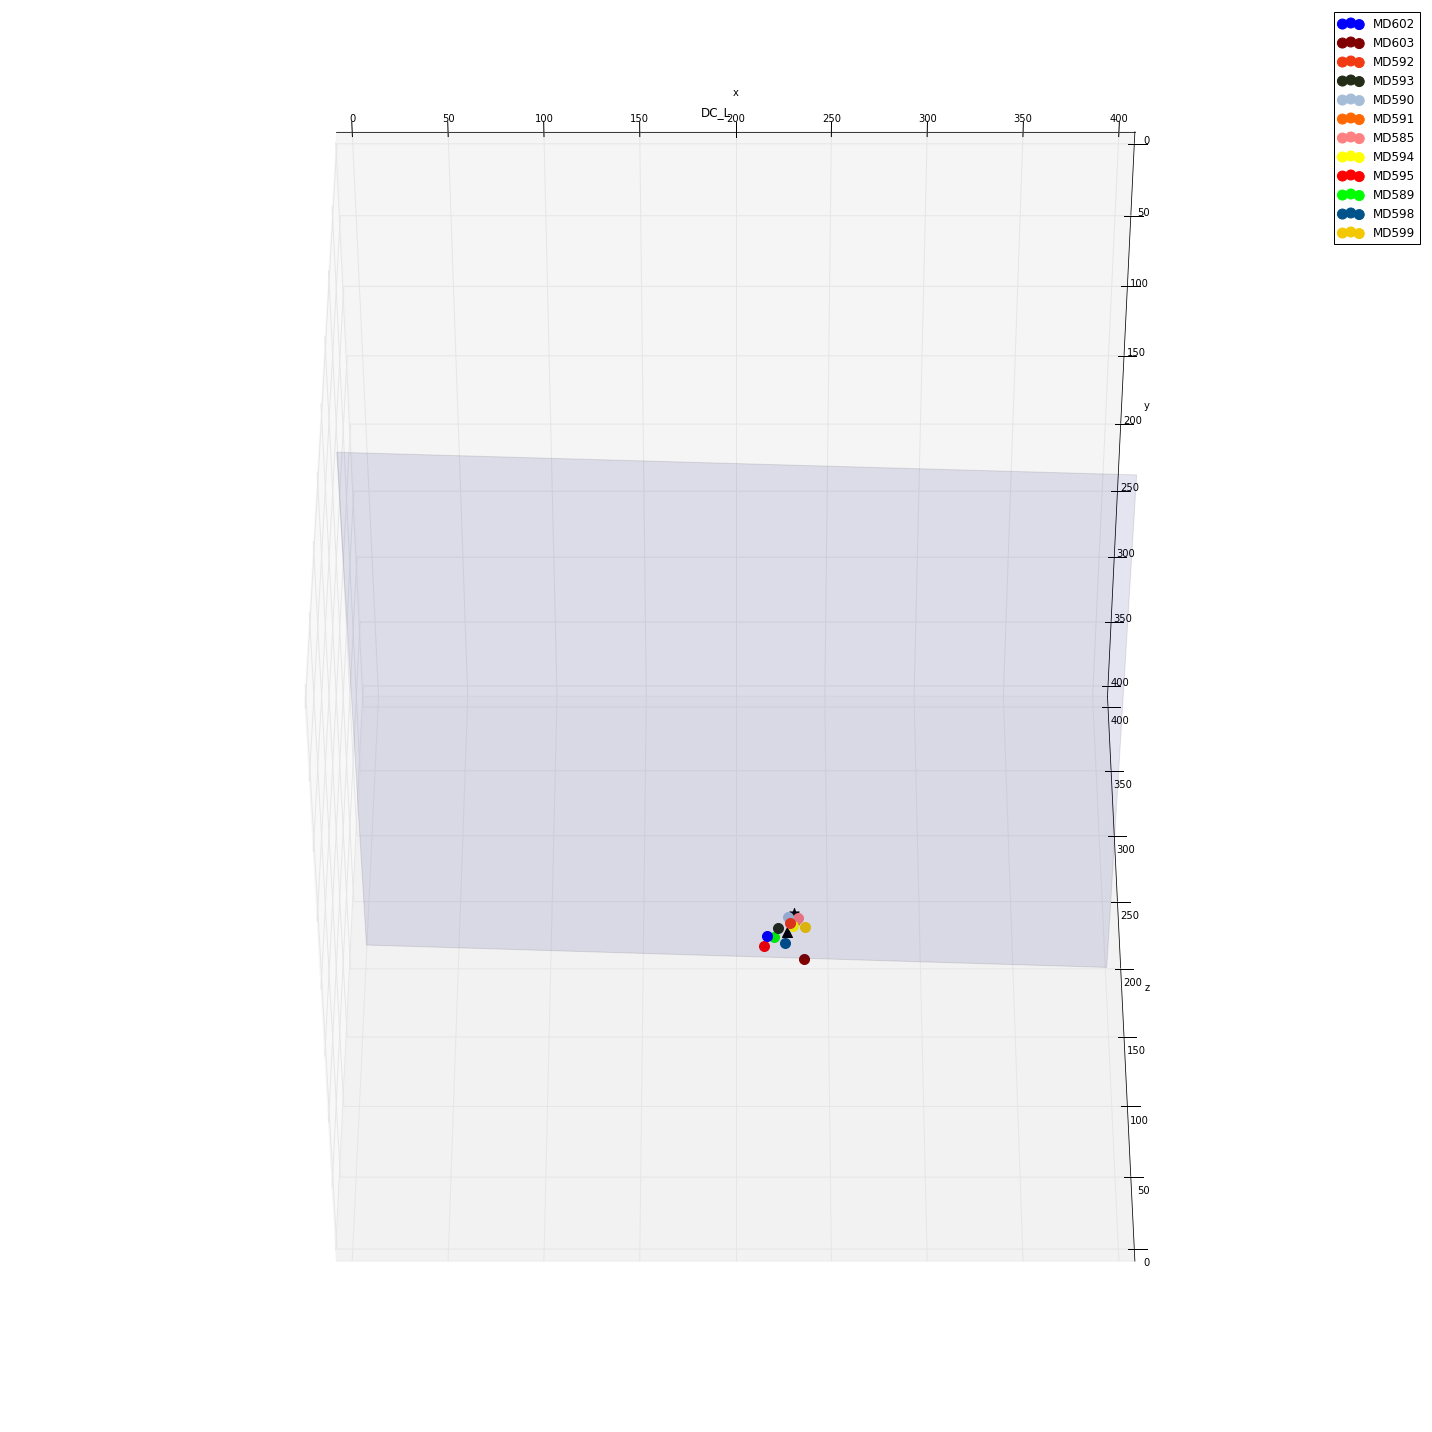

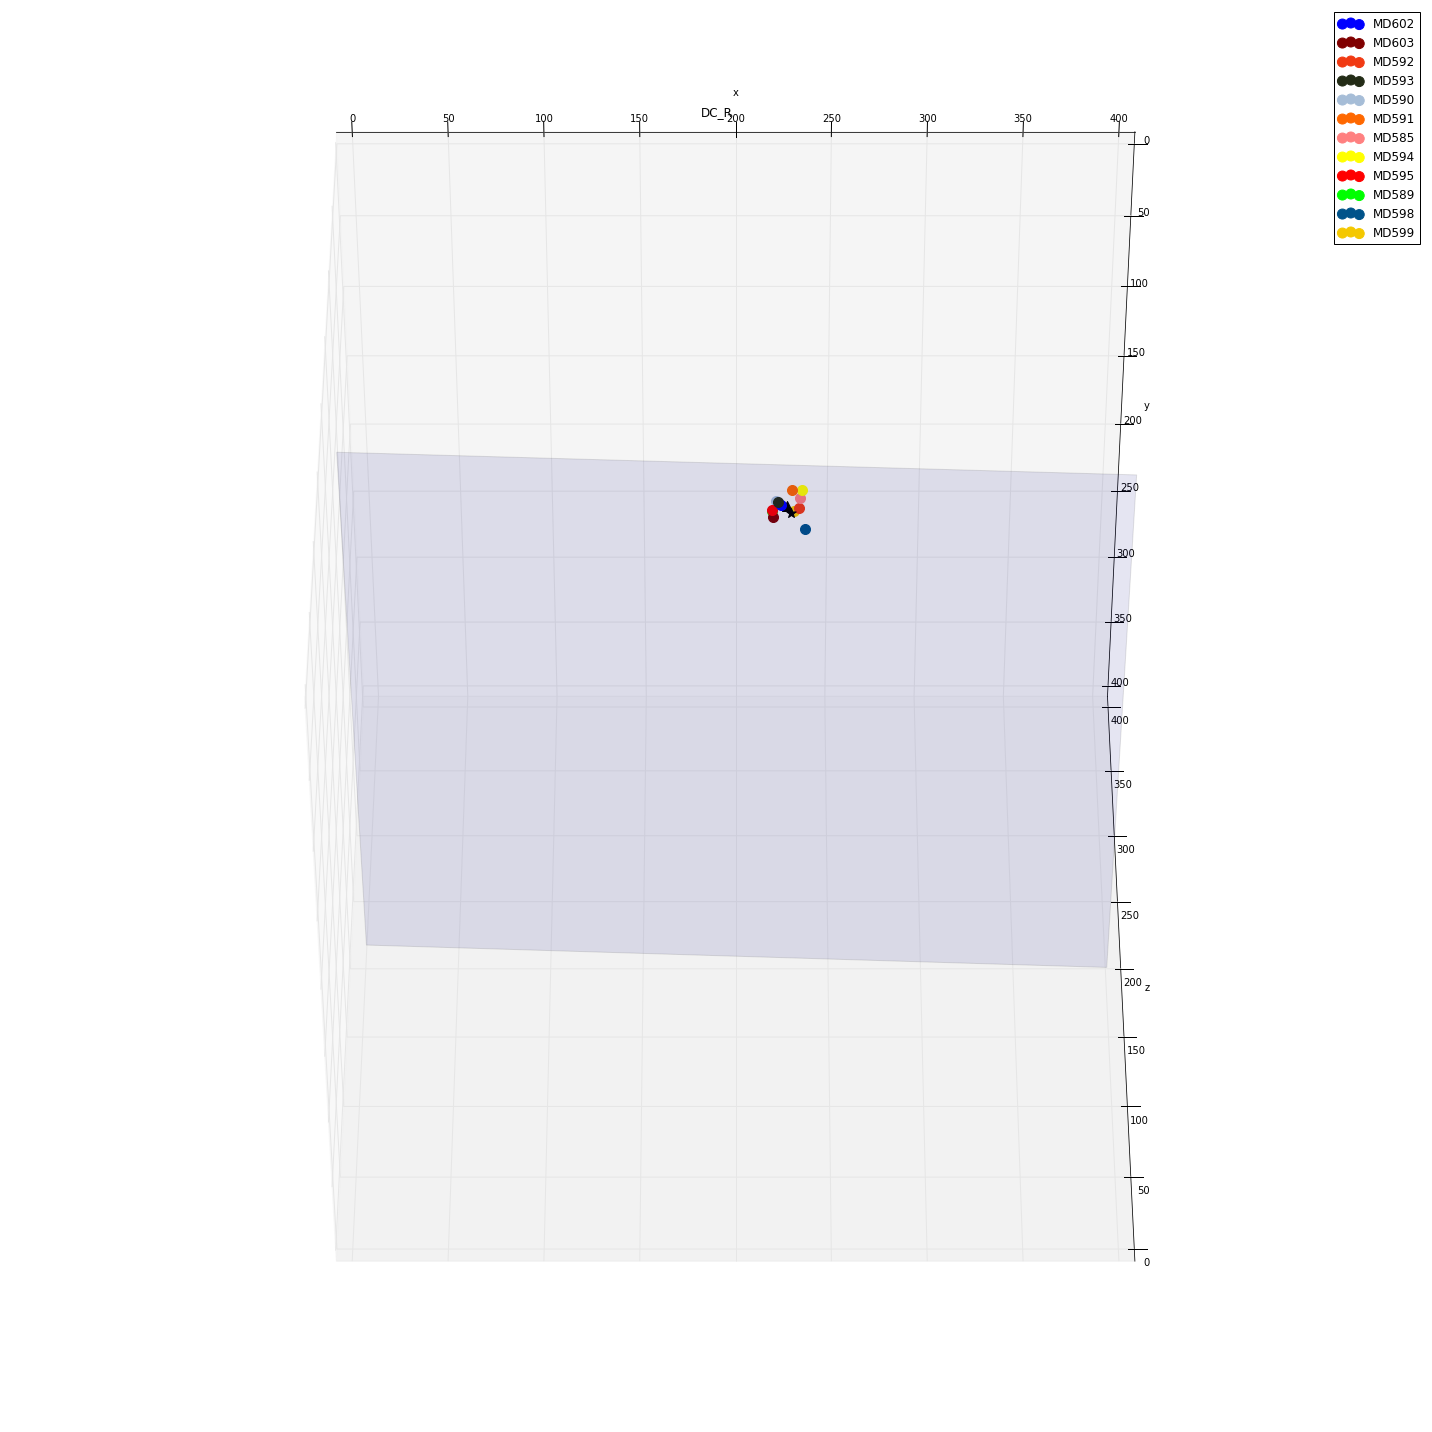

KeyboardInterrupt: 

In [82]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

for ss in sorted(all_known_structures_sided):
# for ss in ['PBG_L', 'PBG_R']:

    fig = plt.figure(figsize=(20, 20));
#     fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d')
    
#     for name_s, centroids_rel2fixed in instance_centroids_rel2fixed.iteritems():
#         if name_s == ss:
# #         if convert_to_original_name(name_s) == ss:
# #         if True:
#             centroids = np.array(centroids_rel2fixed)
#             ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                        marker='o', s=100, alpha=.1)

#             c = canonical_locations_rel2fixed[name_s]
#             ax.scatter(c[0], c[1], c[2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

#     #     # Plot uncerntainty ellipsoids
#     #     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     #     v = np.linspace(0.0, np.pi, 100)
#     #     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     #     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     #     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     #     for i in range(len(u)):
#     #         for j in range(len(v)):
#     #             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     #     ax.plot_surface(x, y, z, color='b')
#     #     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)

#     ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#                color=(0,0,0), marker='^', s=200, alpha=.3)

    # Plot mid-sagittal plane
    ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

    #######################################################

    for name_s, centroids_rel2atlas in adjusted_structure_centroids_rel2atlas.iteritems():   
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            for st, c in centroids_rel2atlas.iteritems():
                ax.scatter(c[0], c[1], c[2], 
                       color=np.array(stack_to_color[st])/255., 
                       marker='o', s=100, alpha=1, label=st)

    ##########################################################

    c = canonical_locations_rel2fixed[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='*', s=100, alpha=1.)
    
    ############################################################
    
    c = new_mean_centroids_rel2atlas_allstructures[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='^', s=100, alpha=1.)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # ax.set_axis_off()
    ax.set_xlim3d([0, 400]);
    ax.set_ylim3d([0, 400]);
    ax.set_zlim3d([0, 400]);
    ax.view_init(azim = -90,elev = -45)
    ax.set_aspect(1.0)
    plt.legend()
    plt.title(ss);
    plt.tight_layout();
    plt.show()

In [83]:
%matplotlib inline

Removed 6N_R from MD589 because deviation 536 um is more than 300 um.
Removed Sp5O_L from MD592 because deviation -440 um is more than 300 um.
Removed Sp5O_R from MD595 because deviation -410 um is more than 300 um.
Removed Sp5O_R from MD599 because deviation -572 um is more than 300 um.
Removed Sp5O_R from MD603 because deviation 480 um is more than 300 um.


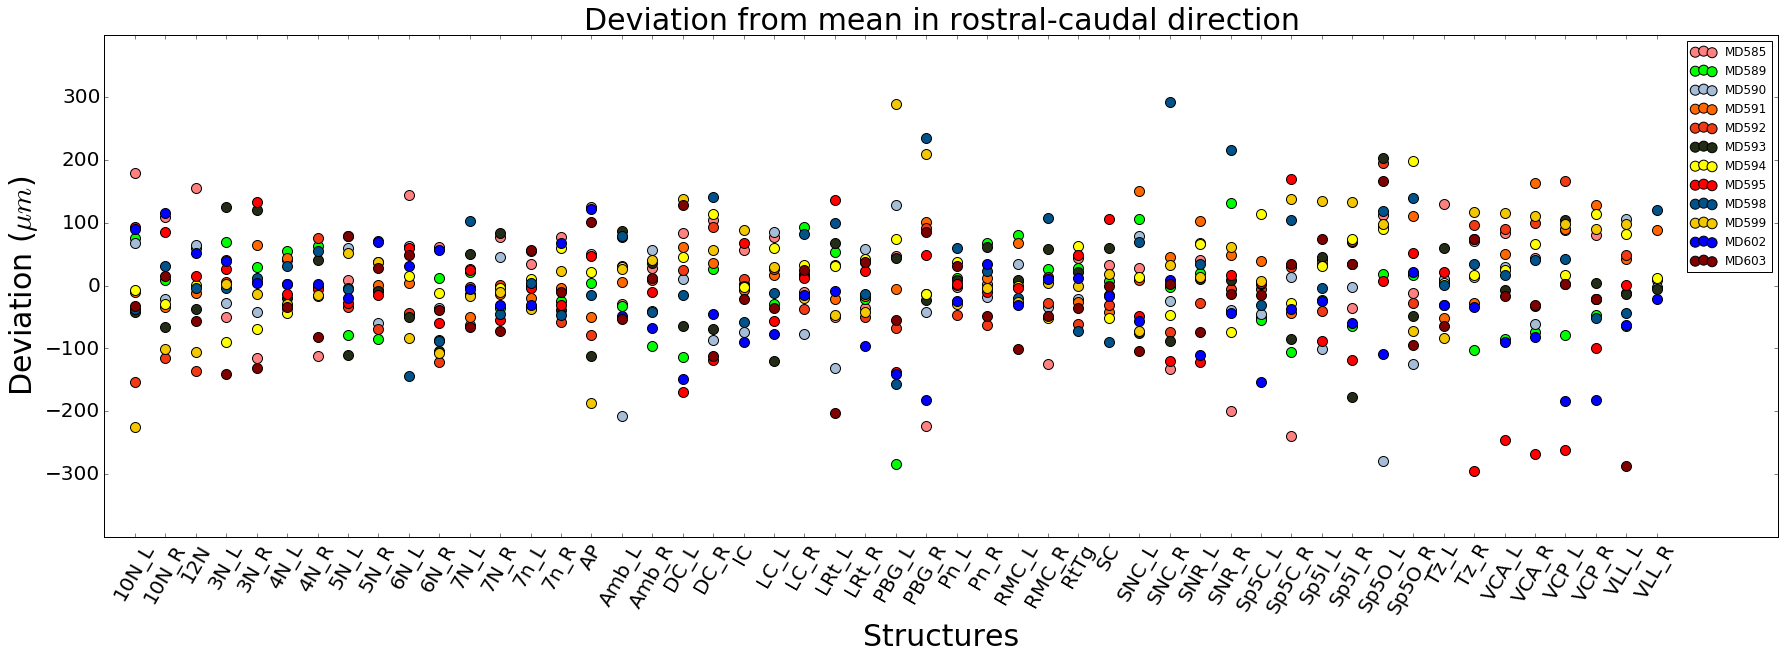

In [135]:
cutoff_um = 300 # Only show those with deviation less than 400um

# plt.figure(figsize=(15,10));
plt.figure(figsize=(30,9));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][0] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s] and \
#            st not in outliers_allstructures[s] and \
           np.abs(instance_centroids_deviations_allstructures[s][st][0] * XY_PIXEL_DISTANCE_LOSSLESS * 32) < cutoff_um]
    
    for s in sorted(all_known_structures_sided):
        if st in instance_centroids_deviations_allstructures[s]:
            d = instance_centroids_deviations_allstructures[s][st][0] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            if np.abs(d) >= cutoff_um:
                print 'Removed %s from %s because deviation %d um is more than %d um.' % (s, st, d, cutoff_um)
    
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st, s=100)
#         else:
#             sys.stderr.write('No data for %s %s: \n' % (st, s))
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='60', fontsize=20);
plt.xlabel('Structures', fontsize=30)
plt.xlim([-1, len(all_known_structures_sided)+3])
# plt.xlim([-1, len(all_known_structures_sided)])
plt.ylabel('Deviation ($\mu m$)', fontsize=30)
plt.yticks(np.arange(-cutoff_um, cutoff_um+1, 100), fontsize=20)
# plt.yticks([], fontsize=20)
plt.title('Deviation from mean in rostral-caudal direction', fontsize=30);
plt.legend()
plt.show()

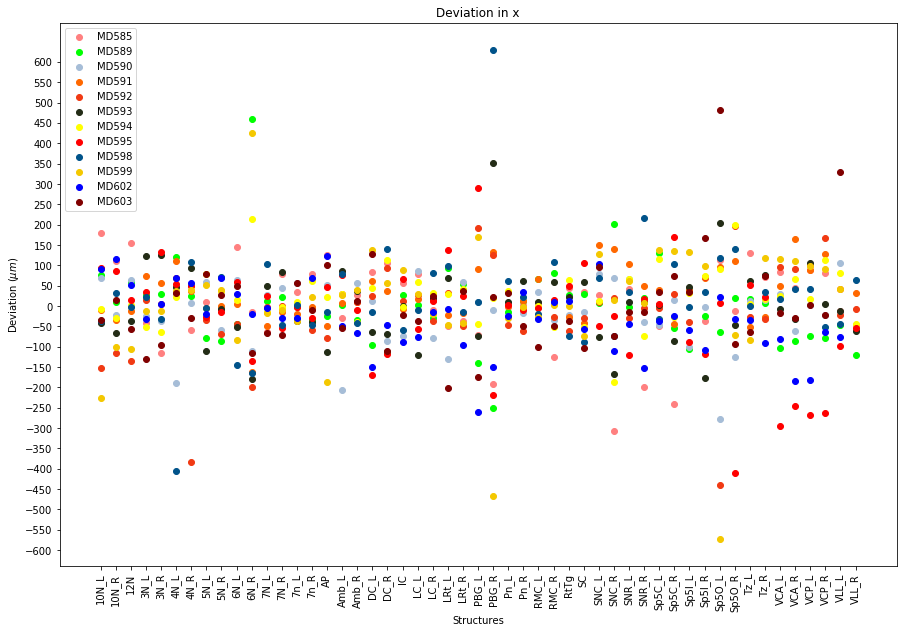

In [124]:
# plt.figure(figsize=(15,10));

# for st in all_nissl_stacks:
#     vals = [instance_centroids_deviations_allstructures[s][st][0] * XY_PIXEL_DISTANCE_LOSSLESS * 32
#             for s in sorted(all_known_structures_sided) 
#             if st in instance_centroids_deviations_allstructures[s]]
#     plt.scatter(range(len(vals)), vals,
#                 c=np.array(stack_to_color[st])/255., label=st)
# #         else:
# #             sys.stderr.write('No data for %s %s: \n' % (st, s))
# plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
# plt.xlabel('Structures')
# plt.ylabel('Deviation ($\mu m$)')
# plt.yticks(np.arange(-600, 650, 50))
# plt.title('Deviation in x');
# plt.legend()
# plt.show()

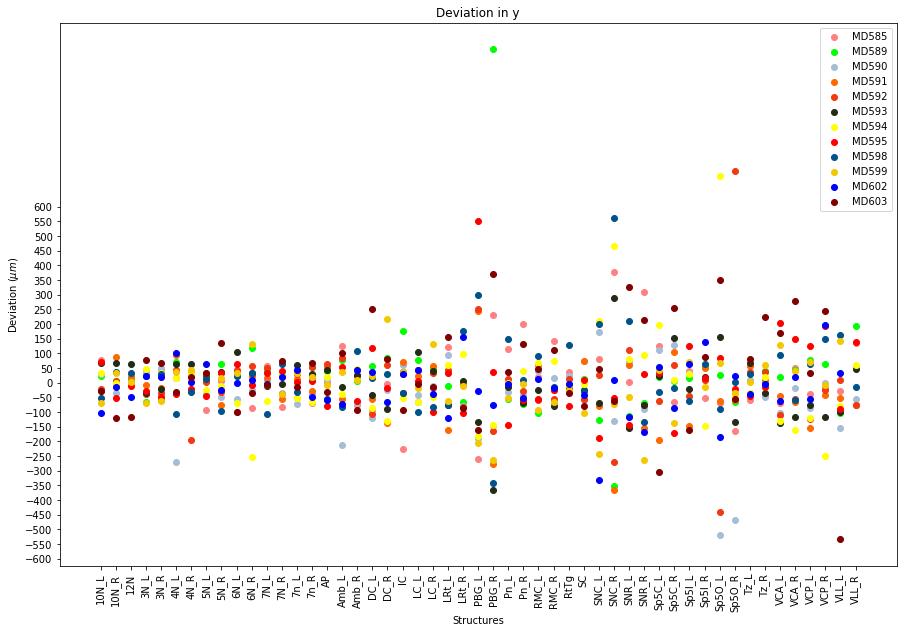

In [105]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][1] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(-600, 650, 50))
plt.title('Deviation in y');
plt.legend()
plt.show()

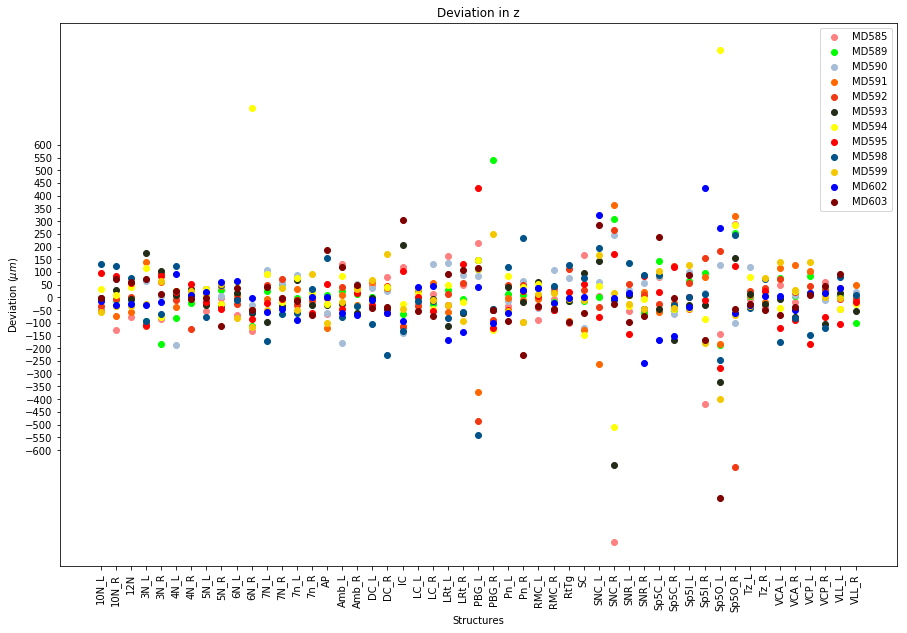

In [106]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [instance_centroids_deviations_allstructures[s][st][2] * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)
plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(-600, 650, 50))
plt.title('Deviation in z');
plt.legend()
plt.show()

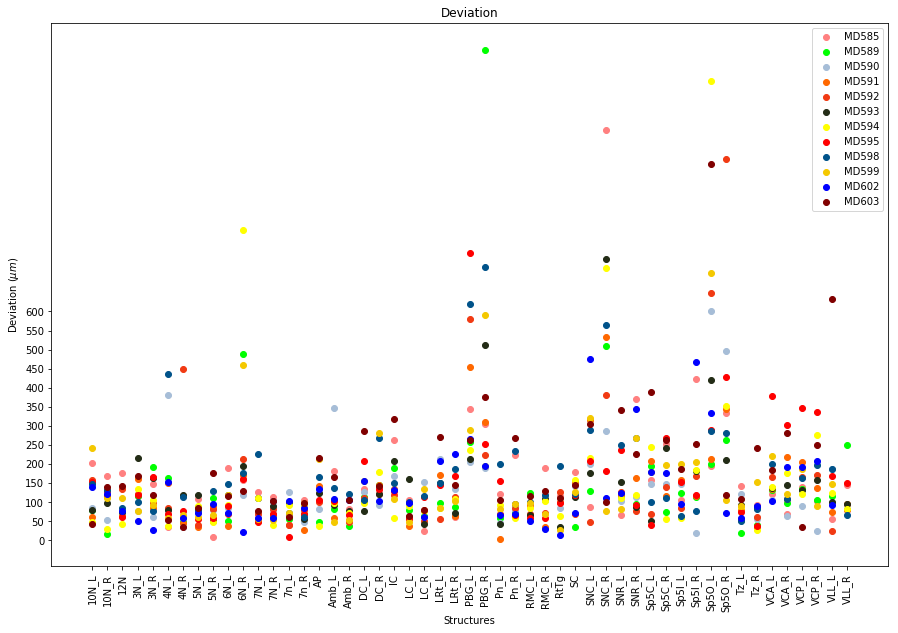

In [109]:
plt.figure(figsize=(15,10));

for st in all_nissl_stacks:
    vals = [np.linalg.norm(instance_centroids_deviations_allstructures[s][st]) * XY_PIXEL_DISTANCE_LOSSLESS * 32
            for s in sorted(all_known_structures_sided) 
            if st in instance_centroids_deviations_allstructures[s]]
    plt.scatter(range(len(vals)), vals,
                c=np.array(stack_to_color[st])/255., label=st)

plt.xticks(range(len(all_known_structures_sided)), sorted(all_known_structures_sided), rotation='90');
plt.xlabel('Structures')
plt.ylabel('Deviation ($\mu m$)')
plt.yticks(np.arange(0, 650, 50))
plt.title('Deviation (x,y,z combined)');
plt.legend()
plt.show()